#Intitialization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from dateutil.parser import parse as dateparse
import time
from collections import Counter
from tqdm.notebook import tqdm
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from datetime import datetime
from dateutil.parser import parse as dateparse
import pickle
import csv
import ast

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MultiLabelBinarizer, QuantileTransformer, OneHotEncoder, LabelBinarizer, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, accuracy_score,classification_report, make_scorer, balanced_accuracy_score, coverage_error, roc_auc_score, confusion_matrix, plot_confusion_matrix, multilabel_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.utils import class_weight
import sklearn as sk

from mpl_toolkits import mplot3d

from xgboost import XGBClassifier
import xgboost as xgb

# !pip install shap
# import shap

# !pip install lime
# import lime
# from lime import lime_text
# from lime.lime_text import LimeTextExplainer
# from lime.explanation import Explanation

In [ ]:
from google.colab import drive, files
# drive.mount('/content/drive')

FILELOC = "/content/drive/My Drive/COVID_Python/"

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
    tpu_env=True
except ValueError:
    print('Not connected to a TPU runtime.')
    tpu_env=False

Not connected to a TPU runtime.


#Utility tasks for paper

In [ ]:
# with open('mylibrary.txt') as f:
#     rawcontents = f.readlines()
# contents = [c.split('{')[1].split(',')[0] for c in rawcontents if c[0]=='@']
# contents.sort()
# with open('citekeys.txt','w') as f:
#     for c in contents:
#         f.write(c+'\n')
# with open('bib.txt', encoding='utf-16') as f:
#     contents = f.readlines()
# import re
# with open('newbib.txt', 'w', encoding='utf-16') as f:
#     for c in tqdm(contents):
#         r = re.sub(re.compile('abstractNote=\{\w*\}, '),'',c)
#         r = re.sub(re.compile('@book'),'@article',r)
#         f.write(r)

In [ ]:
# metadf = pd.read_csv(FILELOC+'metadata.tsv', '\t')
# metadf.iloc[0]['Location']
# metadf['continent'] = metadf['Location'].apply(lambda x: x.split('/')[0].strip())
# metadf.continent.value_counts()
# metadf.continent.value_counts().values/len(metadf)

# mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')
# mdf['continent'] = mdf['Location'].apply(lambda x: x.split('/')[0].strip())
# mdf.continent.value_counts()
# mdf.continent.value_counts()/len(mdf)
# mdf['country'] = mdf['Location'].apply(lambda x: x.split('/')[1].strip())
# mdf[mdf.continent=='Asia']['country'].value_counts()/len(mdf)

In [ ]:
# metadf = pd.read_csv(FILELOC+'metadata.tsv', '\t')
# omi = pd.read_csv(FILELOC + 'omicron_spike_20211209.csv')
# omi.rename(columns={'SeqID':'Accession ID'},inplace=True)
# omi.to_excel('EpiList_omicron.xls',index=False)
# seqidlist = pd.concat([metadf[['Accession ID']],omi[['Accession ID']]])
# seqidlist.to_csv('EpiList.txt',index=False,header=False)
# !tar -cvzf EpiList.txt.gz EpiList.txt

# mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
# rdf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')
# print(len(mdf),len(rdf))
# omi = pd.read_csv(FILELOC + 'omicron_spike_20211209.csv')
# epilist = rdf['Accession ID'].to_list() + omi['SeqID'].to_list()
# np.savetxt('EpiList_20220105.csv',epilist,fmt='%s',delimiter=',')

In [ ]:
# reflist = {}
# for k in range(7):
#     reflist[k] = pd.read_csv(f'Exported Items ({k}).csv')
# pd.concat([reflist[k] for k in range(7)], axis=0).to_csv('items_from_mybib20220105.csv',index=False)

In [ ]:
# !tar -xvf '/content/drive/My Drive/COVID_Python/metadata_tsv_2022_01_06.tar.xz' -C '/content/drive/My Drive/COVID_Python/'
# !tar -xvf '/content/drive/My Drive/COVID_Python/metadata_tsv_2022_01_06.tar.xz' -C '/content/drive/My Drive/COVID_Python/'
# !tar -xvf '/content/drive/My Drive/COVID_Python/spikeprot0104.tar.tar.xz' -C '/content/drive/My Drive/COVID_Python/'
# !tar -xvf '/content/drive/My Drive/COVID_Python/spikeprot0104.tar' -C '/content/drive/My Drive/COVID_Python/'

In [ ]:
mdf = pd.read_csv(FILELOC + 'metadata.tsv', '\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
Location_Parsed = mdf['Location'].apply(lambda x: x.split('/'))
mdf['Country'] = [x[1].strip() for x in Location_Parsed]
mdf['Continent'] = [x[0].strip() for x in Location_Parsed]

In [ ]:
REFDATE = '2019-12-01'; refdt = dateparse(REFDATE)
def f(x):
    return (dateparse(x) - refdt).days
mdf['reldate'] = mdf['Collection date'].apply(f)
mdf.drop(mdf[mdf.reldate < 0].index, inplace=True)

In [ ]:
from datetime import timedelta

In [ ]:
datebins = np.arange(0,800,30); datebins[-1] = 1000; print(datebins)
datebinnames = [(refdt + timedelta(int(datebins[d]))).strftime('%b %Y')\
                for d in range(len(datebins-1))]
bindate = np.digitize(mdf.reldate,datebins)
mdf['datehist'] = bindate

[   0   30   60   90  120  150  180  210  240  270  300  330  360  390
  420  450  480  510  540  570  600  630  660  690  720  750 1000]


In [ ]:
countdf = mdf.groupby(['Continent','datehist']).size().to_frame().reset_index(drop=False).rename(columns={0:'count'})

In [ ]:
def f(x):
    d, c = x
    if d in countdf[countdf.Continent==c]['datehist'].tolist():
        return countdf.loc[(countdf.Continent==c) & (countdf.datehist==d)]['count'].values[0]
    else:
        return 0

continent_set = set(countdf.Continent)
plotdata_dict = {c:[f([d,c]) for d in range(1,len(datebins))] for c in continent_set}
plotdata = pd.DataFrame.from_dict(plotdata_dict)

In [ ]:
# for c in plotdata.columns:
#     if sum(plotdata[c]) < 0.05:
#         plotdata.drop(columns=c, inplace=True)
# plotdata.drop(columns = 'None', inplace=True)

In [ ]:
datebinnames[-1] = 'Jan 2022'
plotdata['Sample Date'] = datebinnames[1:]

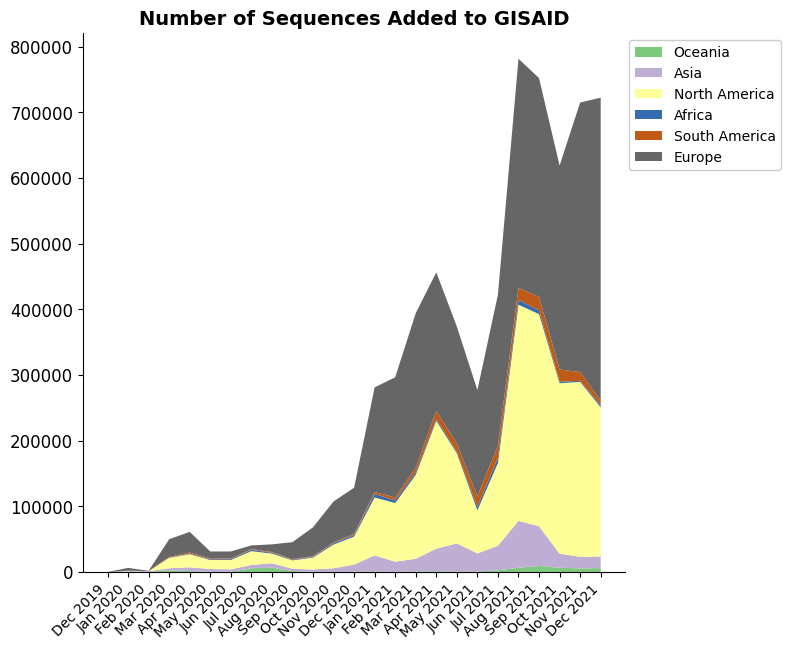

In [ ]:
colormap = plt.cm.get_cmap('Accent')

plt.rcdefaults()
fig,ax = plt.subplots()
fig.set_size_inches(7,7)

ax.set_prop_cycle('color', [colormap(i) for i in np.linspace(0, 1, len(continent_set))])
ax.stackplot(plotdata['Sample Date'][:-1],[plotdata[c].values[:-1] for c in continent_set],
             labels=continent_set)

ax.set_title('Number of Sequences Added to GISAID', fontsize=14, fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlabel('Collection Date', fontsize=14, fontweight='bold')
# ax.set_ylabel('Sequences', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=12)
ax.legend(bbox_to_anchor=(1.3, 1.0), framealpha=1.0)

plt.show()

In [ ]:
# for the caption, include the raw totals through January 7, 2022
mdf.Continent.value_counts()

Europe           3580307
North America    2474436
Asia              448385
South America     163440
Africa             66513
Oceania            62861
Name: Continent, dtype: int64

In [ ]:
country_list = list(mdf.Country.value_counts().head(30).index)
country_list[country_list.index('Czech Republic')] = 'Czechia'
seq_counts = list(mdf.Country.value_counts().head(30).values)

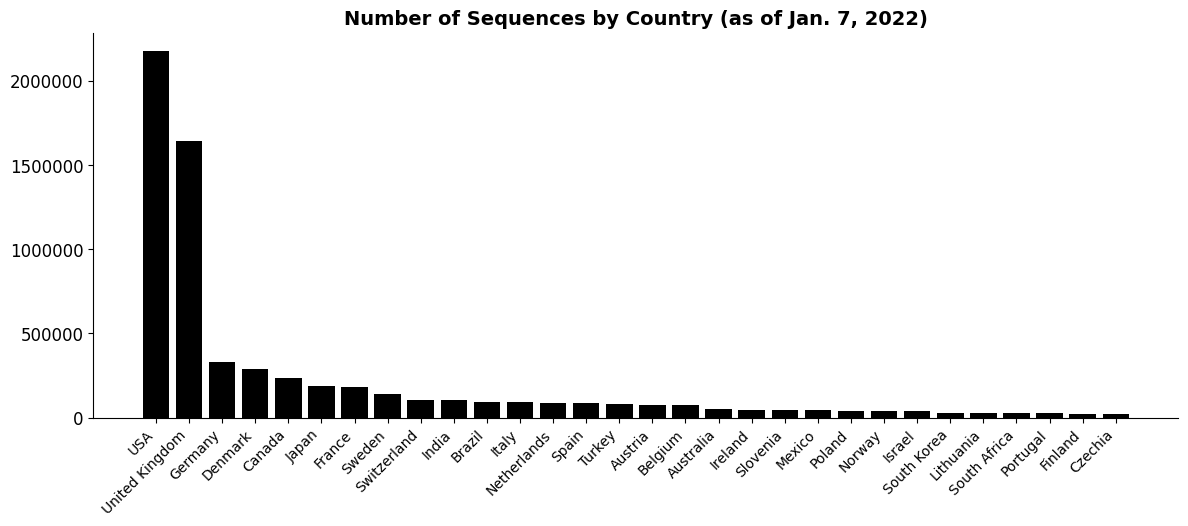

In [ ]:
plt.rcdefaults()
fig,ax = plt.subplots()
fig.set_size_inches(14,5)

ax.bar(country_list, seq_counts, color='black')

ax.set_title('Number of Sequences by Country (as of Jan. 7, 2022)', fontsize=14, fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlabel('Country', fontsize=14, fontweight='bold')
# ax.set_ylabel('Sequences', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=12)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
# ax.legend(bbox_to_anchor=(1.3, 1.0), framealpha=1.0)

plt.show()

Hasell, J., Mathieu, E., Beltekian, D. et al. A cross-country database of COVID-19 testing. Sci Data 7, 345 (2020). https://doi.org/10.1038/s41597-020-00688-8

https://github.com/owid/covid-19-data/tree/master/public/data

In [ ]:
coviddf = pd.read_csv(FILELOC + 'owid-covid-data.csv')

In [ ]:
totalcases = coviddf.groupby(['location'])['new_cases'].sum().to_frame().rename(columns={'new_cases':'cases'})
totalcases['country'] = totalcases.index
totalcases.loc['United States','country'] = 'USA'
totalcases.set_index('country',inplace=True,drop=True)

In [ ]:
cases_list = [totalcases.loc[c,'cases'] for c in country_list]

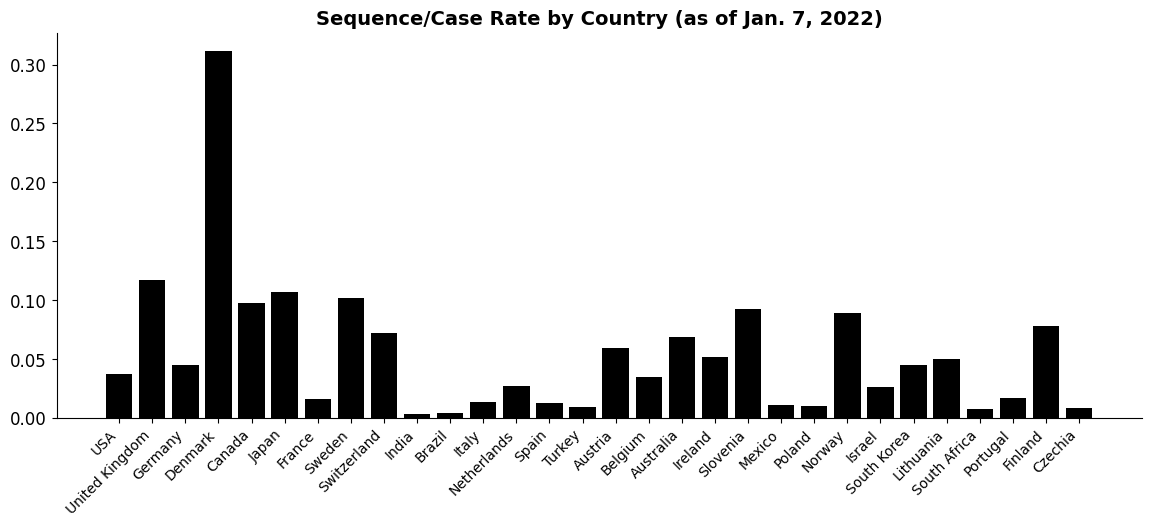

In [ ]:
plt.rcdefaults()
fig,ax = plt.subplots()
fig.set_size_inches(14,5)

ax.bar(country_list, np.array(seq_counts)/np.array(cases_list), color='black')

ax.set_title('Sequence/Case Rate by Country (as of Jan. 7, 2022)', fontsize=14, fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlabel('Country', fontsize=14, fontweight='bold')
# ax.set_ylabel('Sequences', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=12)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
# ax.legend(bbox_to_anchor=(1.3, 1.0), framealpha=1.0)

plt.show()

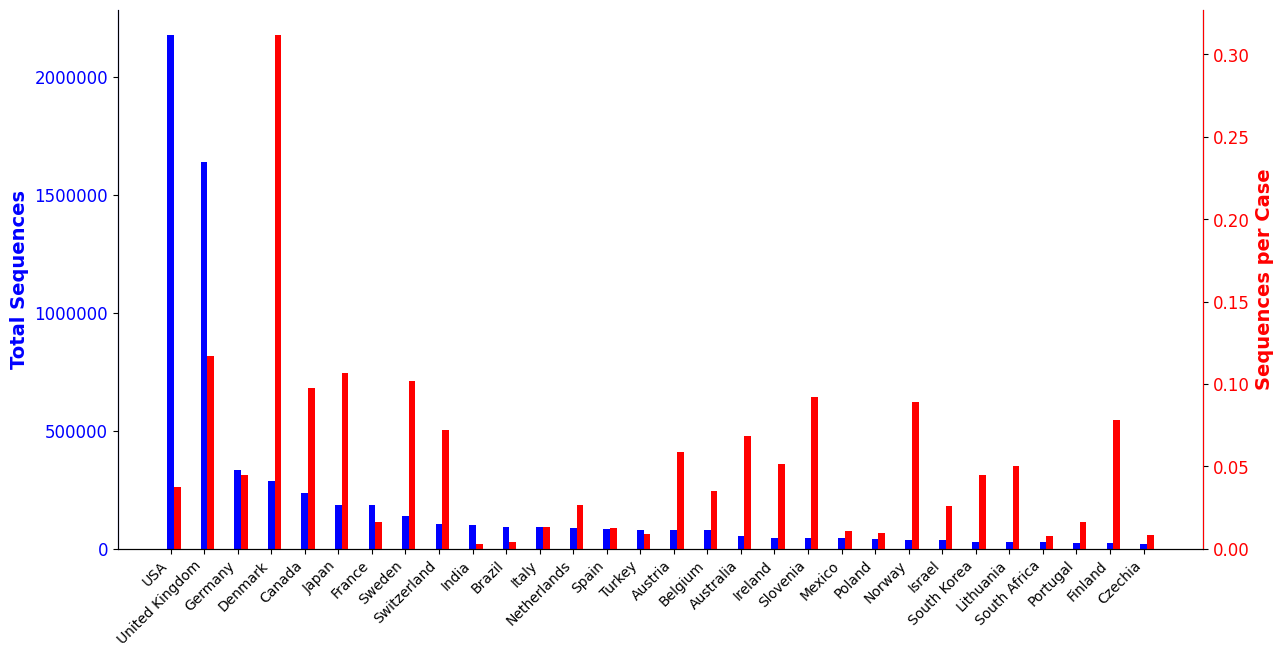

In [ ]:
plt.rcdefaults()
fig,ax = plt.subplots()
fig.set_size_inches(14,7)

width = 0.2

ax.bar(np.arange(len(country_list)), seq_counts,
       width, color='blue')
ax.set_ylabel('Total Sequences', fontsize=14, fontweight='bold', color='blue')




ax2 = ax.twinx()
ax2.bar(np.arange(len(country_list))+width, np.array(seq_counts)/np.array(cases_list),
        width, color='red')
ax2.set_ylabel('Sequences per Case', fontsize=14, fontweight='bold', color='red')

ax.set_xticks(np.arange(len(country_list)))
ax.set_xticklabels([country_list[k] for k in np.arange(len(country_list))],
                   rotation=45, fontsize=10, ha='right')
# plt.xticks(rotation=45, fontsize=10, ha='right')
ax.tick_params(axis="y", labelsize=12, labelcolor='blue')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('blue')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('red')

ax2.tick_params(axis="y", labelsize=12, labelcolor='red')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
# ax.legend(bbox_to_anchor=(1.3, 1.0), framealpha=1.0)

plt.show()

In [ ]:
totalseqs = mdf.Country.value_counts().to_frame().rename(columns={'Country':'seqs'})

In [ ]:
seqrate = totalcases.join(totalseqs,how='inner')

In [ ]:
seqrate['rate'] = seqrate[['cases','seqs']].apply(lambda x:x[1]/x[0], axis=1)

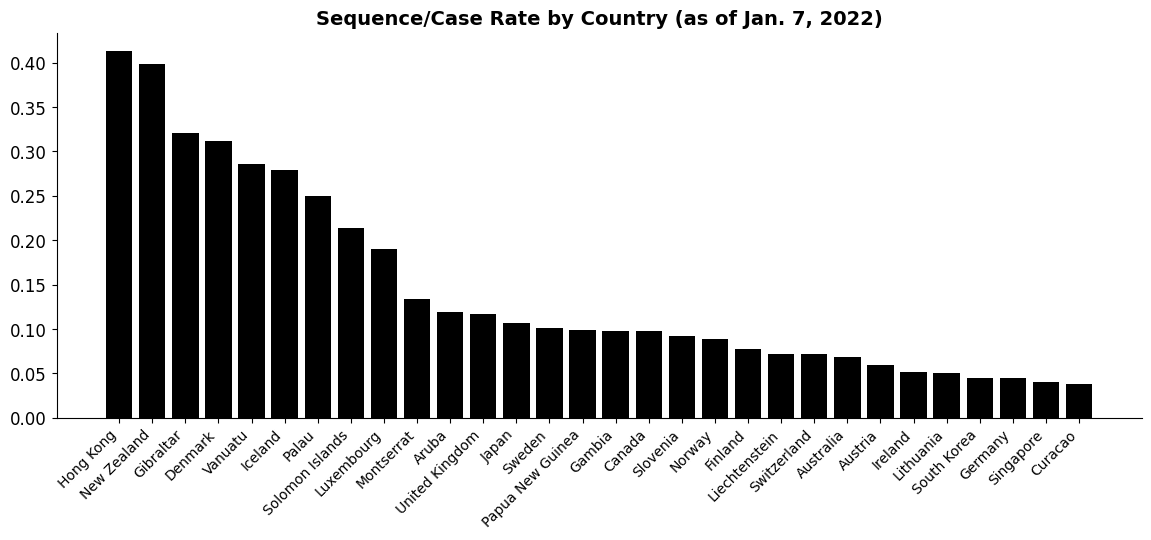

In [ ]:
plt.rcdefaults()
fig,ax = plt.subplots()
fig.set_size_inches(14,5)

top_seqrate = seqrate.sort_values(by='rate', ascending=False).head(30)
ax.bar(top_seqrate.index, top_seqrate.rate.values, color='black')

ax.set_title('Sequence/Case Rate by Country (as of Jan. 7, 2022)', fontsize=14, fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlabel('Country', fontsize=14, fontweight='bold')
# ax.set_ylabel('Sequences', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=12)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
# ax.legend(bbox_to_anchor=(1.3, 1.0), framealpha=1.0)

plt.show()

# Patient Data Analysis

In [ ]:
# with open(FILELOC + 'backup_patient_analysis.pkl', 'rb') as f:
#     train_index_list, test_index_list, train_labels_list, test_labels_list, train_data_list, test_data_list, train_predict_list, test_predict_list, attention_wts, embedding_wts, data = pickle.load(f)
# data.drop(columns='sample_weight', inplace=True)
# with open(FILELOC + 'backup_patient_analysis_2.pkl', 'rb') as f:
#     train_index_list, test_index_list, train_labels_list, test_labels_list, train_data_list, test_data_list, train_predict_list, test_predict_list, attention_wts, embedding_wts, data = pickle.load(f)
# data.drop(columns='sample_weight', inplace=True)

In [ ]:
mdf = pd.read_csv(FILELOC + "patient_spike_ism_20210811.tsv", "\t")

mdf['ISM'] = mdf['MaskedSeq']
mdf.rename(columns={'Pango lineage':'Pango', 'Clade_x':'Clade', 'Gender_x':'Gender_Raw',
                    'Collection date_x':'Collection date', 'AA Substitutions_x':'AA Substitutions',
                    'Virus name_x':'Virus name', 'Location_x':'Location',
                    'Additional location information_x':'Additional location information',
                    'Host_x':'Host'}, inplace=True)
mdf.drop(columns='MaskedSeq', inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mdf.rename(columns={'Patient age_x':'Age_Raw'}, inplace=True)
try:
    agemapdf
except:
    # the map file should define any "unknown" as -1
    agemapdf = pd.read_csv(FILELOC + 'age_map_20210811.tsv', '\t', encoding='ISO-8859-1', dtype={'Original':'str', 'Processed':'Int64'})
    agemap = dict(zip(agemapdf.Original, agemapdf.Processed))
    
mdf['Age'] = mdf['Age_Raw'].map(agemap).fillna(-1)

In [ ]:
mdf.rename(columns={'Corrected status':'Status'}, inplace=True)
statusmapdf = pd.read_csv(FILELOC + "patient_status_map_20210811.tsv", "\t")
catmapdf = pd.read_csv(FILELOC + "patient_status_reduced_map_20210811.csv")
statusmap = dict(zip(statusmapdf['Original'].apply(lambda x: x.lower()),
                     statusmapdf['Map1'].apply(lambda x: x.lower())))
catmap = dict(zip(catmapdf['Status'].apply(lambda x: x.lower()),
                  catmapdf['Category'].apply(lambda x: x.lower())))
mdf['Category'] = mdf['Status'].apply(lambda x: x.lower()).map(statusmap).map(catmap)
mdf['Category'] = mdf['Category'].fillna('unknown')

# labelmap = {'alive' : 0,
#             'asymptomatic' : 0,
#             'dead' : 1,
#             'hospitalized' : 1,
#             'mild' : 0,
#             'moderate' : 1,
#             'released' : 1,
#             'screening' : 0,
#             'severe' : 1,
#             'symptomatic' : 1,
#             'unknown' : -1,
#            }
labelmap = {'alive' : -1,
            'asymptomatic' : 0,
            'dead' : 1,
            'hospitalized' : 1,
            'mild' : 0,
            'moderate' : 0,
            'released' : 1,
            'screening' : 0,
            'severe' : 1,
            'symptomatic' : -1,
            'unknown' : -1,
           }

mdf['Label'] = mdf['Category'].map(labelmap).astype(int)

In [ ]:
# for p, c in zip(mdf.Pango.value_counts()[:25].index, mdf.Pango.value_counts()[:25].values):
#     npm = np.mean(data[data.ISM.isin(mdf[mdf.Pango == p]['ISM'])]['TestError'])
#     avlab = np.mean(data[data.ISM.isin(mdf[mdf.Pango == p]['ISM'])]['Label'])
#     avagem = np.mean(mdf[(mdf.Pango==p) & (mdf.Age!=-1) & (mdf.Label==0)]['Age'].values)
#     avages = np.mean(mdf[(mdf.Pango==p) & (mdf.Age!=-1) & (mdf.Label==1)]['Age'].values)
#     print(f"Pango = {p:12}, MSE = {npm:6.4}, Ave.Label = {avlab:5.3}, Ave.Age.Mild - {avagem:4.1f}, Ave.Age.Sev = {avages:4.1f}, Count = {c}")

In [ ]:
mdf_backup = mdf.copy()

print("Dropping invalid ISM values", len(mdf))
mdf.drop(mdf[mdf.ISM.str.contains('\*')].index, inplace=True)
print(len(mdf))
mdf.drop(mdf[mdf.ISM.str.contains('X')].index, inplace=True)
print(len(mdf))
mdf.reset_index(drop=True, inplace=True)

print("Dropping invalid label values", len(mdf))
mdf.drop(mdf[mdf.Label==-1].index, inplace=True)
print(len(mdf))
mdf.reset_index(drop=True, inplace=True)

Dropping invalid ISM values 104776
100218
80670
Dropping invalid label values 80670
39071


In [ ]:
# data = mdf.copy()

# countdata = data.groupby(["ISM","Label"]).size().to_frame().rename(columns={0:"Count"})
# newdata = pd.DataFrame(data.ISM.value_counts()).rename(columns={"ISM":"Count"})
# newdata['Count_Dict'] = [countdata.loc[ind].to_dict()["Count"] for ind in newdata.index]
# newdata = newdata.reset_index(drop=False).rename(columns={"index":"ISM"})
# label_list = np.zeros(len(newdata))
# for ind in newdata.index:
#     elem = newdata.Count_Dict[ind]
#     if len(elem) == 2:
#         label_list[ind] = newdata.Count_Dict[ind][1] / newdata.Count[ind]
#     elif 0 in elem:
#         label_list[ind] = 0
#     elif 1 in elem:
#         label_list[ind] = 1
# newdata['Label'] = label_list
# totalcount = np.sum(newdata.Count)
# newdata['sample_weight'] = newdata['Count'].apply(lambda x: x/totalcount*10)

# data = newdata.copy()

In [ ]:
mdf2 = pd.read_csv(FILELOC + 'align0912_spike.csv')
print(len(mdf2))
patdf = pd.read_csv(FILELOC + 'GISAID_patient_metadata_20210812_0912.tsv', '\t')
print(len(patdf))
mdf2 = pd.merge(left=mdf2[['SequenceID','MaskedSeq']], right = patdf,
                left_on = 'SequenceID', right_on='Accession ID')
print(len(mdf2))
mdf2.rename(columns = {'MaskedSeq':'ISM'}, inplace=True)
mdf2.rename(columns={'Corrected status':'Status', 'Gender':'Gender_Raw',
                     'Patient age':'Age_Raw'}, inplace=True)
Location_Parsed = mdf2['Location'].apply(lambda x: x.split('/'))
mdf2['Country'] = [x[1].strip() for x in Location_Parsed]
agemapdf = pd.read_csv(FILELOC + 'age_map_20210812_0912.tsv', '\t', encoding='ISO-8859-1', dtype={'Original':'str', 'Processed':'Int64'})
agemap = dict(zip(agemapdf.Original, agemapdf.Processed))
mdf2['Age'] = mdf2['Age_Raw'].map(agemap).fillna(-1)

statusmapdf = pd.read_csv(FILELOC + "patient_status_map_20210812_0912.tsv", "\t")
catmapdf = pd.read_csv(FILELOC + "patient_status_reduced_map_20210811.csv")
statusmap = dict(zip(statusmapdf['Original'].apply(lambda x: x.lower()),
                     statusmapdf['Map1'].apply(lambda x: x.lower())))
catmap = dict(zip(catmapdf['Status'].apply(lambda x: x.lower()),
                  catmapdf['Category'].apply(lambda x: x.lower())))
mdf2['Category'] = mdf2['Status'].apply(lambda x: x.lower()).map(statusmap).map(catmap)
mdf2['Category'] = mdf2['Category'].fillna('unknown')
mdf2['Label'] = mdf2['Category'].map(labelmap).astype(int)

22167
23073
22166


In [ ]:
mdf2_backup = mdf2.copy()

print("Dropping invalid ISM values", len(mdf2))
mdf2.drop(mdf2[mdf2.ISM.str.contains('\*')].index, inplace=True)
print(len(mdf2))
mdf2.drop(mdf2[mdf2.ISM.str.contains('X')].index, inplace=True)
print(len(mdf2))
mdf2.reset_index(drop=True, inplace=True)
print("Dropping invalid label values", len(mdf2))
mdf2.drop(mdf2[mdf2.Label==-1].index, inplace=True)
print(len(mdf2))
mdf2.reset_index(drop=True, inplace=True)

Dropping invalid ISM values 22166
21031
13442
Dropping invalid label values 13442
7264


In [ ]:
# data2 = mdf2.copy()

# countdata = data2.groupby(["ISM","Label"]).size().to_frame().rename(columns={0:"Count"})
# newdata = pd.DataFrame(data2.ISM.value_counts()).rename(columns={"ISM":"Count"})
# newdata['Count_Dict'] = [countdata.loc[ind].to_dict()["Count"] for ind in newdata.index]
# newdata = newdata.reset_index(drop=False).rename(columns={"index":"ISM"})
# label_list = np.zeros(len(newdata))
# for ind in newdata.index:
#     elem = newdata.Count_Dict[ind]
#     if len(elem) == 2:
#         label_list[ind] = newdata.Count_Dict[ind][1] / newdata.Count[ind]
#     elif 0 in elem:
#         label_list[ind] = 0
#     elif 1 in elem:
#         label_list[ind] = 1
# newdata['Label'] = label_list
# totalcount = np.sum(newdata.Count)
# newdata['sample_weight'] = newdata['Count'].apply(lambda x: x/totalcount*10)
# data2 = newdata.copy()

Create merged dataset

In [ ]:
print(len(mdf), len(mdf2), len(mdf)+len(mdf2))
metadf = pd.concat([mdf[mdf2.columns], mdf2])
print(len(metadf))

39071 7264 46335
46335


In [ ]:
# D = pd.merge(data, data2, on='ISM', suffixes=('_1', '_2'), how='outer')
# D['Count_1'] = D.Count_1.fillna(0); D['Count_2'] = D.Count_2.fillna(0)
# D['Label_1'] = D.Label_1.fillna(0); D['Label_2'] = D.Label_2.fillna(0)
# D['Count'] = D[['Count_1', 'Count_2']].apply(lambda x: x[0]+x[1], axis=1)
# D['Label'] = D[['Count_1', 'Label_1', 'Count_2', 'Label_2']].apply(lambda x: (x[0]/(x[0]+x[2]))*x[1] + (x[2]/(x[0]+x[2]))*x[3], axis=1)
# D = D[['ISM', 'Count', 'Label', 'Count_1', 'Count_2', 'Label_1', 'Label_2', 'Count_Dict_1', 'Count_Dict_2']]

Make Age-Corrected DataSet

In [ ]:
data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
data.reset_index(drop=True, inplace=True)

In [ ]:
bins = [-2,0,20,30,40,50,60,70,80,150]
cats = ['Unknown', '0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']

In [ ]:
# force unknown ages to have an average label of 0.5

agedf = metadf[['Age', 'Label']]
agegrp = agedf.groupby([pd.cut(agedf['Age'], bins=bins, labels=cats),
                        'Label']).size().to_frame().rename(columns={0:'Count'})
agebin_dict = {cat:{} for cat in cats}
for ind, count in agegrp.to_dict()['Count'].items():
    cat, label = ind
    agebin_dict[cat][label] = count
agehist = pd.DataFrame.from_dict(agebin_dict, orient='index')
agehist['Label'] = agehist[[0,1]].apply(lambda x: x[1]/(x[1]+x[0]), axis=1)
agehist['Bin'] = range(0,len(agehist))
agehist.loc['Unknown', 'Label'] = 0.5

In [ ]:
agehist

,0,1,Label,Bin
Unknown,890,1027,0.500000,0
0-20,3081,1582,0.339267,1
21-30,3834,3176,0.453067,2
31-40,3424,4072,0.543223,3
41-50,3051,3910,0.561701,4
51-60,2386,4084,0.631221,5
61-70,1355,3580,0.725431,6
71-80,854,2827,0.767998,7
81+,754,2448,0.764522,8


In [ ]:
def f(x):
    h,_ = np.histogram(metadf[metadf.ISM==x]['Age'], bins)
    return np.sum(np.multiply(h, agehist['Label'].values)) / np.sum(h)
data['AgeLabel'] = data['ISM'].apply(f)
data['MeanAge'] = data['ISM'].apply(lambda x: np.mean(metadf[(metadf.ISM==x) & (metadf.Age!=-1)]['Age']))

In [ ]:
def f(x):
    if x[0] > x[1]:
        return 0.5*(x[0]-x[1])/(1-x[1]) + 0.5
    else:
        return 0.5 - 0.5*(x[1]-x[0])/x[1]

data['AdjLabel'] = data[['Label','AgeLabel']].apply(f, axis=1)

In [ ]:
# data.to_csv(FILELOC + 'covid_agepatient_crossval/covid_agepatient_alldata_20211003.csv', index=False)

#Dataset creation Pipelines

###Combine and pre-process patient metadata files

In [ ]:
origdf = pd.read_csv(FILELOC + "GISAID_patient_metadata_20210811.tsv", '\t')
patdf = pd.read_csv(FILELOC + 'GISAID_patient_metadata_20210812_0912.tsv', '\t')
newdf = pd.read_csv(FILELOC + 'GISAID_patient_metadata_20210913_1004_raw.tsv', '\t')
print(len(origdf), len(patdf), len(newdf))

113680 23073 18792


In [ ]:
def proc_df(mdf2, patientstatusmapfile, agemapfile):

    labelmap = {'alive' : -1,
                'asymptomatic' : 0,
                'dead' : 1,
                'hospitalized' : 1,
                'mild' : 0,
                'moderate' : 0,
                'released' : 1,
                'screening' : 0,
                'severe' : 1,
                'symptomatic' : -1,
                'unknown' : -1,
            }

    mdf2.rename(columns={'Corrected status':'Status', 'Gender':'Gender_Raw',
                        'Patient age':'Age_Raw'}, inplace=True)
    Location_Parsed = mdf2['Location'].apply(lambda x: x.split('/'))
    mdf2['Country'] = [x[1].strip() for x in Location_Parsed]
    agemapdf = pd.read_csv(agemapfile, '\t', encoding='ISO-8859-1', dtype={'Original':'str', 'Processed':'Int64'})
    agemap = dict(zip(agemapdf.Original, agemapdf.Processed))
    mdf2['Age'] = mdf2['Age_Raw'].map(agemap).fillna(-1)

    statusmapdf = pd.read_csv(patientstatusmapfile, "\t")
    catmapdf = pd.read_csv(FILELOC + "patient_status_reduced_map_20210811.csv")
    statusmap = dict(zip(statusmapdf['Original'].apply(lambda x: x.lower()),
                        statusmapdf['Map1'].apply(lambda x: x.lower())))
    catmap = dict(zip(catmapdf['Status'].apply(lambda x: x.lower()),
                    catmapdf['Category'].apply(lambda x: x.lower())))
    mdf2['Category'] = mdf2['Status'].apply(lambda x: x.lower()).map(statusmap).map(catmap)
    mdf2['Category'] = mdf2['Category'].fillna('unknown')
    mdf2['Label'] = mdf2['Category'].map(labelmap).astype(int)

    return mdf2

In [ ]:
odf = proc_df(origdf, FILELOC+'patient_status_map_20210811.tsv',
              FILELOC+'age_map_20210811.tsv')
pdf = proc_df(patdf, FILELOC+'patient_status_map_20210812_0912.tsv',
              FILELOC+'age_map_20210812_0912.tsv')
ndf = proc_df(newdf, FILELOC+'patient_status_map_20210913_1004.tsv',
              FILELOC+'age_map_20210913_1004.tsv')

In [ ]:
# !tar -xvf '/content/drive/My Drive/COVID_Python/results1001_Spike.tar.gz' -C '/content/drive/My Drive/COVID_Python/'
# seqs = pd.read_csv(FILELOC + 'results1001_Spike.csv')
# seqlist = pd.concat([origdf['Accession ID'],patdf['Accession ID'],newdf['Accession ID']],
#                     axis=0, ignore_index=True).to_frame()
# seqlist.loc[len(seqlist)] = 'EPI_ISL_402124' # add reference sequence
# print(len(seqs), len(seqlist))
# selseqs = pd.merge(left=seqs,right=seqlist,left_on='SequenceID',right_on='Accession ID')
# print(len(selseqs))
# selseqs.to_csv(FILELOC + 'results_1001_Spike_selected.csv', index=False)

In [ ]:
alldf = pd.concat([odf, pdf, ndf], ignore_index=True, axis=0)

###Example of merging sequence data with patient metadata and creating a training dataset of unique sequences

In [ ]:
seqs = pd.read_csv(FILELOC + 'alignout1001.csv')

In [ ]:
seqs = pd.merge(alldf, seqs, left_on='Accession ID', right_on='SequenceID')

In [ ]:
seqs.rename(columns={'MaskedSeq':'ISM'}, inplace=True)

In [ ]:
seqs_backup = seqs.copy()

In [ ]:
print("Dropping invalid sequence values", len(seqs))
seqs.drop(seqs[seqs.ISM.str.contains('\*')].index, inplace=True)
print(len(seqs))
seqs.drop(seqs[seqs.ISM.str.contains('X')].index, inplace=True)
print(len(seqs))
seqs.reset_index(drop=True, inplace=True)
print("Dropping invalid label values", len(seqs))
seqs.drop(seqs[seqs.Label==-1].index, inplace=True)
print(len(seqs))
seqs.reset_index(drop=True, inplace=True)

Dropping invalid sequence values 147169
139906
105241
Dropping invalid label values 105241
54081


In [ ]:
# with open(FILELOC + 'patientdata_all_20211008.pkl', 'wb') as f:
#     pickle.dump([alldf, seqs_backup, seqs], f)

In [ ]:
alldata = seqs.copy()

countdata = alldata.groupby(["ISM","Label"]).size().to_frame().rename(columns={0:"Count"})
newdata = pd.DataFrame(alldata.ISM.value_counts()).rename(columns={"ISM":"Count"})
newdata['Count_Dict'] = [countdata.loc[ind].to_dict()["Count"] for ind in newdata.index]
newdata = newdata.reset_index(drop=False).rename(columns={"index":"ISM"})
label_list = np.zeros(len(newdata))
for ind in newdata.index:
    elem = newdata.Count_Dict[ind]
    if len(elem) == 2:
        label_list[ind] = newdata.Count_Dict[ind][1] / newdata.Count[ind]
    elif 0 in elem:
        label_list[ind] = 0
    elif 1 in elem:
        label_list[ind] = 1
newdata['Label'] = label_list
totalcount = np.sum(newdata.Count)
newdata['sample_weight'] = newdata['Count'].apply(lambda x: x/totalcount*10)
alldata = newdata.copy()

In [ ]:
alldata.to_csv(FILELOC + 'covid_patient_updated_data_20211008.csv', index=False)

##Create cross-validation datasets

In [ ]:
data = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
data.reset_index(drop=True, inplace=True)
np.savetxt(FILELOC + 'covid_rawseqs_crossval/TrainLabels.csv', data.Label)
with open(FILELOC + 'covid_rawseqs_crossval/TrainData.csv', 'w') as f:
    csv.writer(f).writerows(data.ISM.values)

random_state_split = 32687     # for splitting
NSplits = 10  ## Number of folds
skf = KFold(n_splits = NSplits, shuffle = True, random_state = random_state_split)
fold=0
for train_index, test_index in skf.split(data):
    np.savetxt(FILELOC + 'covid_rawseqs_crossval/TrainIndex_'+str(fold)+'.csv', train_index, '%i', delimiter=',')
    np.savetxt(FILELOC + 'covid_rawseqs_crossval/TestIndex_'+str(fold)+'.csv', test_index, '%i', delimiter=',')
    fold += 1

In [ ]:
data = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
data.reset_index(drop=True, inplace=True)
np.savetxt(FILELOC + 'covid_aligned_crossval/TrainLabels.csv', data.Label)
with open(FILELOC + 'covid_aligned_crossval/TrainData.csv', 'w') as f:
    csv.writer(f).writerows(data.ISM.values)

random_state_split = 32687     # for splitting
NSplits = 10  ## Number of folds
skf = KFold(n_splits = NSplits, shuffle = True, random_state = random_state_split)
fold=0
for train_index, test_index in skf.split(data):
    np.savetxt(FILELOC + 'covid_aligned_crossval/TrainIndex_'+str(fold)+'.csv', train_index, '%i', delimiter=',')
    np.savetxt(FILELOC + 'covid_aligned_crossval/TestIndex_'+str(fold)+'.csv', test_index, '%i', delimiter=',')
    fold += 1

In [ ]:
data = pd.read_csv(FILELOC + 'covid_filtered_crossval/covid_patient_0912_filtered_sequences.csv')
data.reset_index(drop=True, inplace=True)
np.savetxt(FILELOC + 'covid_filtered_crossval/TrainLabels.csv', data.Label)
with open(FILELOC + 'covid_filtered_crossval/TrainData.csv', 'w') as f:
    csv.writer(f).writerows(data.ISM.values)

random_state_split = 32687     # for splitting
NSplits = 10  ## Number of folds
skf = KFold(n_splits = NSplits, shuffle = True, random_state = random_state_split)
fold=0
for train_index, test_index in skf.split(data):
    np.savetxt(FILELOC + 'covid_filtered_crossval/TrainIndex_'+str(fold)+'.csv', train_index, '%i', delimiter=',')
    np.savetxt(FILELOC + 'covid_filtered_crossval/TestIndex_'+str(fold)+'.csv', test_index, '%i', delimiter=',')
    fold += 1

###Generating the age-corrected data used in cross-validation experiments (obsolete)

In [ ]:
data = pd.read_csv(FILELOC + 'covid_agepatient_crossval/covid_agepatient_alldata_20211003.csv')
data.reset_index(drop=True, inplace=True)

In [ ]:
updated_data = pd.read_csv(FILELOC + 'covid_patient_updated_data_20211008.csv')
updated_data = updated_data[updated_data.Count>=5]

In [ ]:
print(len(data), len(updated_data))

716 812


In [ ]:
val_data = updated_data[~updated_data.ISM.isin(data.ISM)].copy()

In [ ]:
bins = [-2,0,20,30,40,50,60,70,80,150]
cats = ['Unknown', '0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']

In [ ]:
# force unknown ages to have an average label of 0.5

agedf = metadf[['Age', 'Label']]
agegrp = agedf.groupby([pd.cut(agedf['Age'], bins=bins, labels=cats),
                        'Label']).size().to_frame().rename(columns={0:'Count'})
agebin_dict = {cat:{} for cat in cats}
for ind, count in agegrp.to_dict()['Count'].items():
    cat, label = ind
    agebin_dict[cat][label] = count
agehist = pd.DataFrame.from_dict(agebin_dict, orient='index')
agehist['Label'] = agehist[[0,1]].apply(lambda x: x[1]/(x[1]+x[0]), axis=1)
agehist['Bin'] = range(0,len(agehist))
agehist.loc['Unknown', 'Label'] = 0.5

In [ ]:
def f(x):
    h,_ = np.histogram(metadf[metadf.ISM==x]['Age'], bins)
    return np.sum(np.multiply(h, agehist['Label'].values)) / np.sum(h)
val_data['AgeLabel'] = val_data['ISM'].apply(f)
val_data['MeanAge'] = val_data['ISM'].apply(lambda x: np.mean(metadf[(metadf.ISM==x) & (metadf.Age!=-1)]['Age']))
val_data['MeanAge'] = val_data['MeanAge'].fillna(-1)

In [ ]:
def f(x):
    if x[0] > x[1]:
        return 0.5*(x[0]-x[1])/(1-x[1]) + 0.5
    else:
        return 0.5 - 0.5*(x[1]-x[0])/x[1]

val_data['AdjLabel'] = val_data[['Label','AgeLabel']].apply(f, axis=1)

In [ ]:
val_data.to_csv(FILELOC + 'covid_validation_dataset_20211008.csv', index=False)
# data.to_csv(FILELOC + 'covid_agepatient_crossval/covid_agepatient_alldata_20211003.csv', index=False)

###Age-corrected TrainLabel dataset (only for full analysis) (obsolete)

In [ ]:
# data = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
# mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
data = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')

def f(x):
    if  x >= 98:
        return 98
    else:
        return x
mdf['EffAge'] = mdf['Age'].apply(f)

In [ ]:
metadf = pd.merge(left=mdf[['ISM', 'Label', 'EffAge']], right=data['ISM'], on='ISM', how='right')
print(len(mdf), len(data), len(metadf))

147181 903 90421


In [ ]:
agehist = metadf[metadf.EffAge!=-1].EffAge.value_counts()

agedict = {'Age':agehist.index, 'Count':agehist.values,
           'MeanLabel':[np.mean(metadf[(metadf.EffAge==a) & (metadf.Label!=-1)]['Label']) for a in agehist.index]}
agedf = pd.DataFrame.from_dict(agedict)
agedf = agedf.sort_values(by='Age', ascending=True)
agedf.set_index('Age', inplace=True, drop=False)

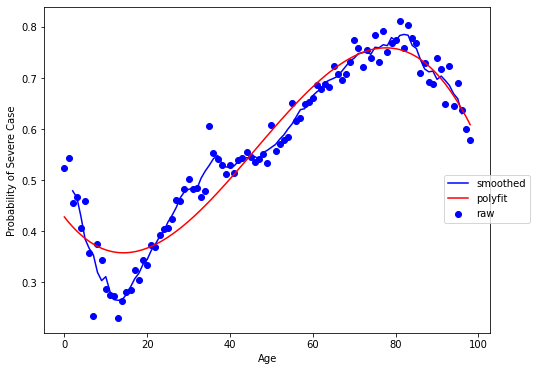

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.scatter(agedf.Age, agedf.MeanLabel, label='raw', color='b')
N=5
ax.plot(agedf.Age.values[int((N-1)/2):int(len(agedf)-(N-1)/2)],
        np.convolve(agedf.MeanLabel, np.ones(N)/N, 'valid'),
        label='smoothed', color='b')
P = 3
coefs = np.polyfit(agedf.Age, agedf.MeanLabel, P)
p = np.poly1d(coefs)
ax.plot(agedf.Age, [p(a) for a in agedf.Age],
        label='polyfit', color='r')

ax.set_xlabel('Age')
ax.set_ylabel('Probability of Severe Case')
ax.legend(bbox_to_anchor=(1.1, 0.5))
# plt.tight_layout()
plt.show()

In [ ]:
N = 5
smooth = agedf.MeanLabel.values.copy()
start = int((N-1)/2); end = int(len(agedf)-(N-1)/2)
smooth[start:end] = np.convolve(agedf.MeanLabel.values, np.ones(N)/N, 'valid')
agedf['SmoothLabel'] = smooth

In [ ]:
agedf['weight0'] = agedf.SmoothLabel.apply(lambda x: 1 + (x - 0.5))
agedf['weight1'] = agedf.SmoothLabel.apply(lambda x: 1 + (0.5 - x))

In [ ]:
# agedf.to_csv(FILELOC + 'covid_aligned_crossval/Age_Weights_0912_aligned.csv', index=False)
agedf.to_csv(FILELOC + 'covid_rawseqs_crossval/Age_Weights_0912_rawseqs.csv', index=False)


In [ ]:
def f(x):
    # x[0] is age, x[1] is label
    if x[0] == -1:
        return 1.0
    if x[1] == -1:
        return 1.0
    if x[1] == 0:
        return agedf.loc[x[0], 'weight0']
    if x[1] == 1:
        return agedf.loc[x[0], 'weight1']

metadf['Weight'] = metadf[['EffAge', 'Label']].apply(f, axis=1)

In [ ]:
data

,ISM,Count,Count_Dict,Label,sample_weight
0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,8583,"{0: 3913, 1: 4670}",0.544099,1.411747
1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5184,"{0: 981, 1: 4203}",0.810764,0.852674
2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,2368,"{0: 969, 1: 1399}",0.590794,0.389493
3,MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1482,"{0: 1299, 1: 183}",0.123482,0.243762
4,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1379,"{0: 238, 1: 1141}",0.827411,0.226820
...,...,...,...,...,...
898,MFVFLVLLPLVSSQCVNFTNRTQLPSAYTNSFTRGVYYPDKVFRSS...,5,{1: 5},1.000000,0.000822
899,MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5,{1: 5},1.000000,0.000822
900,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5,{0: 5},0.000000,0.000822
901,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5,"{0: 4, 1: 1}",0.200000,0.000822


In [ ]:
def f(ism):
    tempdf = metadf[(metadf.ISM == ism) & (metadf.Label != -1)]
    return np.sum(np.multiply(tempdf['Label'].values,
                              tempdf['Weight'].values)) / np.sum(tempdf['Weight'].values)

data['AdjLabel'] = data['ISM'].apply(f)

In [ ]:
np.savetxt(FILELOC + 'covid_rawseqs_crossval/TrainLabels_Age.csv', data.AdjLabel)

##Age-corrected TrainLabel dataset



In [ ]:
data = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
# data = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
# mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')

In [ ]:
mdf = mdf[mdf.ISM.isin(data.ISM)]
mdf = mdf[((mdf.Host == 'Human')|(mdf.Host.isna()))&(mdf.Label != -1)].copy()

In [ ]:
MEAN_SEVERE = np.mean(mdf.Label)
# MEAN_SEVERE = 0.5
print(MEAN_SEVERE)

0.5532183159266186


In [ ]:
agebins = [-2,0,20,30,40,50,60,70,80,1000]
binnames = ['Unknown', '0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']

In [ ]:
mdf['agebin'] = mdf.Age.apply(lambda x: np.digitize(x, agebins[:-1]))
binnums = np.unique(mdf.agebin)
psevere = [mdf[mdf.agebin==a]['Label'].value_counts().loc[1]/len(mdf[mdf.agebin==a]) \
           for a in binnums]
agehist = [len(mdf[mdf.agebin==a]) for a in binnums]
mapdf = pd.DataFrame.from_dict({'Age_Bin':binnums,'LeftBin':agebins[:-1], 'Count':agehist, 'Severe':psevere})
mapdf.loc[0,'Severe'] = MEAN_SEVERE # force unknown ages to have a P_Severe of mean for whole population

<BarContainer object of 9 artists>

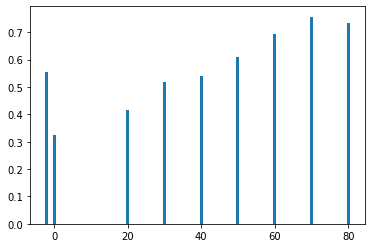

In [ ]:
plt.bar(mapdf.LeftBin, mapdf.Severe)

In [ ]:
def f(severe):
    if severe == 1.0:
        wt0 = 0; wt1 = 1
    elif severe == 0.0:
        wt0 = 1; wt1 = 0
    elif severe > MEAN_SEVERE:
        wt0 = MEAN_SEVERE/(1-severe); wt1 = 1/wt0
    elif severe < MEAN_SEVERE:
        wt1 = MEAN_SEVERE/severe; wt0 = 1/wt1
    elif severe == MEAN_SEVERE:
        wt0 = 1; wt1 = 1
    else:
        wt0 = np.nan; wt1 = np.nan
    return wt0, wt1

weights = mapdf['Severe'].apply(f)
mapdf['Weight_0'] = [w[0] for w in weights]
mapdf['Weight_1'] = [w[1] for w in weights]

In [ ]:
def f(x):
    label, agebin = x
    if label == 0:
        return mapdf.loc[mapdf['Age_Bin']==agebin, 'Weight_0'].values[0]
    elif label == 1:
        return mapdf.loc[mapdf['Age_Bin']==agebin, 'Weight_1'].values[0]

mdf['weight'] = mdf[['Label', 'agebin']].apply(f, axis=1)

In [ ]:
mapdf

,Age_Bin,LeftBin,Count,Severe,Weight_0,Weight_1
0,1,-2,1724,0.553218,1.000000,1.000000
1,2,0,4784,0.324833,0.587169,1.703087
2,3,20,7241,0.415136,0.750402,1.332619
3,4,30,7820,0.517647,0.935701,1.068717
4,5,40,6975,0.538925,0.974163,1.026522
5,6,50,6679,0.609373,1.416230,0.706100
6,7,60,5049,0.694593,1.811413,0.552055
7,8,70,3768,0.756900,2.275684,0.439428
8,9,80,3547,0.733860,2.078671,0.481077


In [ ]:
def f(ism):
    tempdf = mdf[mdf.ISM == ism]
    return np.sum(tempdf.Label.values*tempdf.weight.values) / np.sum(tempdf.weight.values)

data['AdjLabel'] = data['ISM'].apply(f)

In [ ]:
print(np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.617.2']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.617.2']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='A']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='A']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.1.7']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.1.7']['ISM'])].AdjLabel))

0.3354208531820137 0.3570327039257932 0.746441955416513 0.6920684976914406 0.5957316706291506 0.5553298134856568 0.5221571991466494 0.4892699814450606


In [ ]:
# np.savetxt(FILELOC + 'covid_aligned_crossval/TrainLabels_Age.csv', data.AdjLabel)
# mapdf.to_csv(FILELOC + 'covid_aligned_crossval/Age_Weights_0912_aligned.csv', index=False)
# np.savetxt(FILELOC + 'covid_rawseqs_crossval/TrainLabels_Age.csv', data.AdjLabel)
# mapdf.to_csv(FILELOC + 'covid_rawseqs_crossval/Age_Weights_0912_rawseqs.csv', index=False)

##Date-corrected TrainLabel dataset

In [ ]:
data = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
# data = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
# mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')

In [ ]:
mdf = mdf[mdf.ISM.isin(data.ISM)]

In [ ]:
REFDATE = '2019-12-01'; refdt = dateparse(REFDATE)
def f(x):
    return (dateparse(x) - refdt).days
mdf['reldate'] = mdf['Collection date'].apply(f)

In [ ]:
mdf = mdf[(mdf.reldate >= 0)&((mdf.Host == 'Human')|(mdf.Host.isna()))&(mdf.Label != -1)].copy()

In [ ]:
MEAN_SEVERE = np.mean(mdf.Label)
# MEAN_SEVERE = 0.5
print(MEAN_SEVERE)

0.5532183159266186


In [ ]:
datehist, datebins = np.histogram(mdf.reldate, bins=40)

In [ ]:
mdf['datebin'] = mdf.reldate.apply(lambda x: np.digitize(x, datebins[:-1]))
binnums = np.unique(mdf.datebin)
psevere = [mdf[mdf.datebin==d]['Label'].value_counts().loc[1]/len(mdf[mdf.datebin==d]) \
           for d in binnums]

mapdf = pd.DataFrame.from_dict({'Date_Bin':binnums,
                                'LeftBin':[datebins[d] for d in binnums-1],
                                'Count':[datehist[d] for d in binnums-1],
                                'Severe':psevere})

In [ ]:
# mapdf['Severe_Raw'] = mapdf['Severe']

# linreg = sk.linear_model.LinearRegression()
# linreg.fit(mapdf.LeftBin.values.reshape(-1,1),mapdf.Severe_Raw.values.reshape(-1,1))
# ylinpred = linreg.predict(mapdf.LeftBin.values.reshape(-1,1))

# P = 3
# coefs = np.polyfit(mapdf.LeftBin, mapdf.Severe_Raw, P)
# p = np.poly1d(coefs)
# ycubepred = [p(l) for l in mapdf.LeftBin]

# slope = -(mapdf.iloc[0].Severe_Raw - mapdf.iloc[-1].Severe_Raw) / (mapdf.iloc[-1].LeftBin - mapdf.iloc[0].LeftBin)
# intercept = mapdf.iloc[0].Severe_Raw - mapdf.iloc[0].LeftBin * slope
# ysmoothpred = [np.poly1d([slope,intercept])(l) for l in mapdf.LeftBin]

# plt.scatter(mapdf.LeftBin,mapdf.Severe_Raw, color='black')
# plt.plot(mapdf.LeftBin,ylinpred, color='blue')
# plt.plot(mapdf.LeftBin,ycubepred, color='red')
# plt.plot(mapdf.LeftBin,ysmoothpred, color='green')
# plt.show()

# mapdf['Severe'] = ycubepred

In [ ]:
def f(severe):
    if severe == 1.0:
        wt0 = 0; wt1 = 1
    elif severe == 0.0:
        wt0 = 1; wt1 = 0
    elif severe > MEAN_SEVERE:
        # wt0 = count; wt1 = 1
        wt0 = MEAN_SEVERE/(1-severe); wt1 = 1/wt0
        # wt0 = 1/severe; wt1 = severe
    elif severe < MEAN_SEVERE:
        # wt1 - count; wt0 = 1
        wt1 = MEAN_SEVERE/severe; wt0 = 1/wt1
        # wt0 = severe; wt1 = 1/severe
    elif severe == MEAN_SEVERE:
        wt0 = 1; wt1 = 1
    else:
        wt0 = np.nan; wt1 = np.nan
    return wt0, wt1

weights = mapdf['Severe'].apply(f)
mapdf['Weight_0'] = [w[0] for w in weights]
mapdf['Weight_1'] = [w[1] for w in weights]

In [ ]:
def f(x):
    label, datebin = x
    if label == 0:
        return mapdf.loc[mapdf['Date_Bin']==datebin, 'Weight_0'].values[0]
    elif label == 1:
        return mapdf.loc[mapdf['Date_Bin']==datebin, 'Weight_1'].values[0]
mdf['weight'] = mdf[['Label', 'datebin']].apply(f, axis=1)

In [ ]:
def f(ism):
    tempdf = mdf[mdf.ISM == ism]
    return np.sum(tempdf.Label.values*tempdf.weight.values) / np.sum(tempdf.weight.values)

data['AdjLabel'] = data['ISM'].apply(f)

In [ ]:
print(np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.617.2']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.617.2']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1']['ISM'])].AdjLabel),
      '\n',
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='A']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='A']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.1.7']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.1.7']['ISM'])].AdjLabel))

0.3354208531820137 0.4703642784814764 0.746441955416513 0.5538696224511827 
 0.5957316706291506 0.3728089167099877 0.5221571991466494 0.47906408098747316


In [ ]:
# np.savetxt(FILELOC + 'covid_aligned_crossval/TrainLabels_Date.csv', data.AdjLabel)
# mapdf.to_csv(FILELOC + 'covid_aligned_crossval/Date_Weights_0912_aligned.csv', index=False)
# np.savetxt(FILELOC + 'covid_rawseqs_crossval/TrainLabels_Date.csv', data.AdjLabel)
# mapdf.to_csv(FILELOC + 'covid_rawseqs_crossval/Date_Weights_0912_rawseqs.csv', index=False)

##Age & Date-corrected TrainLabel dataset

In [ ]:
# data = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
# mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
data = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')

In [ ]:
mdf = mdf[mdf.ISM.isin(data.ISM)]

REFDATE = '2019-12-01'; refdt = dateparse(REFDATE)
def f(x):
    return (dateparse(x) - refdt).days
mdf['reldate'] = mdf['Collection date'].apply(f)

mdf = mdf[(mdf.reldate >= 0)&((mdf.Host == 'Human')|(mdf.Host.isna()))&(mdf.Label != -1)].copy()

In [ ]:
MEAN_SEVERE = np.mean(mdf.Label)
# MEAN_SEVERE = 0.5
print(MEAN_SEVERE)

0.5527352389779454


In [ ]:
agebins = [-2,0,20,30,40,50,60,70,80,1000]
agebinnames = ['Unknown', '0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']

NBINS = 50
datehist, datebins = np.histogram(mdf.reldate, bins=NBINS)

In [ ]:
mdf['agebin'] = mdf.Age.apply(lambda x: np.digitize(x, agebins[:-1]))
mdf['datebin'] = mdf.reldate.apply(lambda x: np.digitize(x, datebins[:-1]))
mdf['agedatebin'] = mdf[['agebin','datebin']].apply(lambda x: (x[0], x[1]), axis=1)

In [ ]:
agedatebins = np.unique(mdf.agedatebin)
psevere = [sum(mdf[mdf.agedatebin==ad]['Label']) / len(mdf[mdf.agedatebin==ad]) \
           for ad in agedatebins] 
count = [len(mdf[mdf.agedatebin==ad]) for ad in agedatebins]
agedatemapdf = pd.DataFrame.from_dict({'Age_Date_Bin':agedatebins, 'Severe':psevere, 'Count':count})

In [ ]:
# Correct the map so that Ages in Bin 1 (i.e. unknown) do not bias the prob. severe

# Get the mean severities for each date bin
datebinnums = np.unique(mdf['datebin'])
psevere_date = {d: mdf[mdf.datebin==d]['Label'].value_counts().loc[1]/len(mdf[mdf.datebin==d]) \
                for d in datebinnums}

# Replace the age_date bin mean severities for age bin = 1 with these mean severities

for d in datebinnums:
    agedatemapdf.loc[agedatemapdf['Age_Date_Bin'] == (1,d), 'Severe'] = psevere_date[d]

In [ ]:
def f(severe):
    if severe == 1.0:
        wt0 = 0; wt1 = 1
    elif severe == 0.0:
        wt0 = 1; wt1 = 0
    elif severe > MEAN_SEVERE:
        # wt0 = count; wt1 = 1
        wt0 = MEAN_SEVERE/(1-severe); wt1 = 1/wt0
        # wt0 = 1/severe; wt1 = severe
    elif severe < MEAN_SEVERE:
        # wt1 - count; wt0 = 1
        wt1 = MEAN_SEVERE/severe; wt0 = 1/wt1
        # wt0 = severe; wt1 = 1/severe
    elif severe == MEAN_SEVERE:
        wt0 = 1; wt1 = 1
    else:
        wt0 = np.nan; wt1 = np.nan
    return wt0, wt1

weights = agedatemapdf['Severe'].apply(f)
agedatemapdf['Weight_0'] = [w[0] for w in weights]
agedatemapdf['Weight_1'] = [w[1] for w in weights]

In [ ]:
def f(x):
    label, agedatebin = x
    if label == 0:
        return agedatemapdf.loc[agedatemapdf['Age_Date_Bin']==agedatebin, 'Weight_0'].values[0]
    elif label == 1:
        return agedatemapdf.loc[agedatemapdf['Age_Date_Bin']==agedatebin, 'Weight_1'].values[0]
mdf['comb_weight'] = mdf[['Label', 'agedatebin']].apply(f, axis=1)

In [ ]:
# data['NewLabel'] = (data.AdjLabel.values+agedata.AdjLabel.values)/2

def f(ism):
    tempdf = mdf[mdf.ISM == ism]
    return np.sum(tempdf.Label.values*tempdf.comb_weight.values) / np.sum(tempdf.comb_weight.values)

data['AdjLabel'] = data['ISM'].apply(f)

In [ ]:
print(np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.617.2']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.617.2']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1']['ISM'])].AdjLabel),
      '\n',
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='A']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='A']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.1.7']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.1.7']['ISM'])].AdjLabel))

0.3377346746857239 0.48410104897693235 0.7466213332661849 0.5630502666914045 
 0.5957355834816903 0.38207411372118916 0.5200418416096562 0.4731231901859375


In [ ]:
# np.savetxt(FILELOC + 'covid_aligned_crossval/TrainLabels_AgeDate.csv', data.AdjLabel)
# mapdf.to_csv(FILELOC + 'covid_aligned_crossval/AgeDate_Weights_0912_aligned.csv', index=False)
# np.savetxt(FILELOC + 'covid_rawseqs_crossval/TrainLabels_AgeDate.csv', data.AdjLabel)
# mapdf.to_csv(FILELOC + 'covid_rawseqs_crossval/AgeDate_Weights_0912_rawseqs.csv', index=False)

In [ ]:
# valdata = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_valid1001_aligned.csv')
# mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
valdata = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_valid1001_rawseqs.csv')
mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')

In [ ]:
mdf = mdf[mdf.ISM.isin(valdata.ISM)]

REFDATE = '2019-12-01'; refdt = dateparse(REFDATE)
def f(x):
    return (dateparse(x) - refdt).days
mdf['reldate'] = mdf['Collection date'].apply(f)

mdf = mdf[(mdf.reldate >= 0)&((mdf.Host == 'Human')|(mdf.Host.isna()))&(mdf.Label != -1)].copy()

In [ ]:
agedatemapdf['Age_LeftBin'] = agedatemapdf.Age_Date_Bin.apply(lambda x: agebins[x[0]-1])
agedatemapdf['Date_LeftBin'] = agedatemapdf.Age_Date_Bin.apply(lambda x: datebins[x[1]-1])

agebins_inmap = np.unique([x[0] for x in agedatemapdf.Age_Date_Bin])
datebins_inmap = np.unique([x[1] for x in agedatemapdf.Age_Date_Bin])
age_leftbins = np.unique(agedatemapdf.Age_LeftBin)
date_leftbins = np.unique(agedatemapdf.Date_LeftBin)

def f(x):
    age, date = x
    agebin = agebins_inmap[np.digitize(age, age_leftbins) - 1]
    datebin = datebins_inmap[np.digitize(date, date_leftbins) - 1]
    if (agebin, datebin) in agedatemapdf.Age_Date_Bin.tolist():
        return (agebin, datebin)
    else:
        return np.nan

mdf['agedatebin'] = mdf[['Age','reldate']].apply(f, axis=1)

print("Number of invalid bins =", len(mdf[mdf.agedatebin.isna()]))

Number of invalid bins = 4


In [ ]:
def f(x):
    label, agedatebin = x
    if type(agedatebin) is not tuple:
        return 1.0
    if label == 0:
        return agedatemapdf.loc[agedatemapdf['Age_Date_Bin']==agedatebin, 'Weight_0'].values[0]
    elif label == 1:
        return agedatemapdf.loc[agedatemapdf['Age_Date_Bin']==agedatebin, 'Weight_1'].values[0]
mdf['comb_weight'] = mdf[['Label', 'agedatebin']].apply(f, axis=1)

In [ ]:
# data['NewLabel'] = (data.AdjLabel.values+agedata.AdjLabel.values)/2

def f(ism):
    tempdf = mdf[mdf.ISM == ism]
    return np.sum(tempdf.Label.values*tempdf.comb_weight.values) / np.sum(tempdf.comb_weight.values)

valdata['AdjLabel'] = valdata['ISM'].apply(f)

In [ ]:
# valdata.to_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_valid1001_aligned_agedate.csv', index=False)
# valdata.to_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_valid1001_rawseqs_agedate.csv', index=False)

##Multiple corrections

In [ ]:
# data = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
# mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
data = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')

In [ ]:
mdf = mdf[mdf.ISM.isin(data.ISM)]
mdf = mdf[((mdf.Host == 'Human')|(mdf.Host.isna()))&(mdf.Label != -1)].copy()

In [ ]:
REFDATE = '2019-12-01'; refdt = dateparse(REFDATE)
def f(x):
    return (dateparse(x) - refdt).days
mdf['date'] = mdf['Collection date'].apply(f)

def f(x):
    if x.lower() == 'male':
        return 0
    elif x.lower() == 'female':
        return 1
    else:
        return -1
mdf['gender'] = mdf['Gender_Raw'].apply(f)

def f(x):
    if x > 99:
        return 99
    else:
        return x
mdf['age'] = mdf['Age'].apply(f)

In [ ]:
adata = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
rdata = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')

In [ ]:
rlen = rdata.ISM.apply(len)

In [ ]:
len(np.where(rlen>1265)[0])

871

In [ ]:
mdf_clean = mdf[(mdf.age != -1)  & (mdf.date >= 0) & (mdf.gender != -1)]
mdf_date = mdf = mdf[mdf.date >= 0]
mdf_agedate = mdf[(mdf.age != -1)  & (mdf.date >= 0)]
mdf_genderdate = mdf[(mdf.date >= 0) & (mdf.gender != -1)]

In [ ]:
reg_date = LogisticRegression()
reg_clean = LogisticRegression()
reg_date = LogisticRegression()
reg_agedate = LogisticRegression()
reg_genderdate = LogisticRegression()

In [ ]:
reg_clean.fit(mdf_clean[['age','date','gender']].values, mdf_clean.Label)
reg_agedate.fit(mdf_agedate[['age','date']].values, mdf_agedate.Label)
reg_genderdate.fit(mdf_genderdate[['date','gender']].values, mdf_genderdate.Label)
reg_date.fit(mdf_date['date'].values.reshape(-1, 1), mdf_date.Label)

LogisticRegression()

In [ ]:
def f(x):
    age, date, gender = x
    if (gender == -1) and (age == -1):
        y = [date]
        return reg_date.predict_proba(np.array(y).reshape(1,-1))[0][1]
    elif gender == -1:
        y = [age, date]
        return reg_agedate.predict_proba(np.array(y).reshape(1,-1))[0][1]
    elif age == -1:
        y = [gender, date]
        return reg_genderdate.predict_proba(np.array(y).reshape(1,-1))[0][1]
    else:
        y = [age, date, gender]
        return reg_clean.predict_proba(np.array(y).reshape(1,-1))[0][1]

mdf['PredLabel'] = mdf[['age','date','gender']].apply(f, axis=1)

In [ ]:
meanlabel = np.mean(mdf.Label); meanpred = np.mean(mdf.PredLabel)
print(meanlabel, meanpred)

MEAN_SEVERE = 0.5

0.5527352389779454 0.5474322126271768


In [ ]:
def f(x):
    label, pred = x
    if pred >= 0.5:
        if label > pred:
            return 1 - pred
        elif label < pred:
            return 1 / (1 - pred)
    elif pred < 0.5:
        if label > pred:
            return 1 / pred
        else:
            return pred

mdf['weight'] = mdf[['Label', 'PredLabel']].apply(f, axis = 1)

In [ ]:
def f(ism):
    tempdf = mdf[mdf.ISM == ism]
    return np.sum(tempdf.Label.values*tempdf.weight.values) / np.sum(tempdf.weight.values)

data['AdjLabel'] = data['ISM'].apply(f)

In [ ]:
print(np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.617.2']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.617.2']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1']['ISM'])].AdjLabel),
      '\n',
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='A']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='A']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.1.7']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.1.7']['ISM'])].AdjLabel))

0.3377346746857239 0.5654738497637494 0.7466213332661849 0.5754471638492844 
 0.5957355834816903 0.43480393975220905 0.5200418416096562 0.507508761163884


In [ ]:
# np.savetxt(FILELOC + 'covid_aligned_crossval/TrainLabels_Regress.csv', data.AdjLabel)
# np.savetxt(FILELOC + 'covid_rawseqs_crossval/TrainLabels_Regress.csv', data.AdjLabel)

In [ ]:
# valdata = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_valid1001_aligned.csv')
# valmdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
valdata = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
valmdf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')

In [ ]:
valmdf = valmdf[valmdf.ISM.isin(valdata.ISM)]
valmdf = valmdf[((valmdf.Host == 'Human')|(valmdf.Host.isna()))&(valmdf.Label != -1)].copy()

In [ ]:
REFDATE = '2019-12-01'; refdt = dateparse(REFDATE)
def f(x):
    return (dateparse(x) - refdt).days
valmdf['date'] = valmdf['Collection date'].apply(f)

def f(x):
    if x.lower() == 'male':
        return 0
    elif x.lower() == 'female':
        return 1
    else:
        return -1
valmdf['gender'] = valmdf['Gender_Raw'].apply(f)

def f(x):
    if x > 99:
        return 99
    else:
        return x
valmdf['age'] = valmdf['Age'].apply(f)

In [ ]:
def f(x):
    age, date, gender = x
    if (gender == -1) and (age == -1):
        y = [date]
        return reg_date.predict_proba(np.array(y).reshape(1,-1))[0][1]
    elif gender == -1:
        y = [age, date]
        return reg_agedate.predict_proba(np.array(y).reshape(1,-1))[0][1]
    elif age == -1:
        y = [gender, date]
        return reg_genderdate.predict_proba(np.array(y).reshape(1,-1))[0][1]
    else:
        y = [age, date, gender]
        return reg_clean.predict_proba(np.array(y).reshape(1,-1))[0][1]

valmdf['PredLabel'] = valmdf[['age','date','gender']].apply(f, axis=1)

In [ ]:
def f(x):
    label, pred = x
    if pred >= 0.5:
        if label > pred:
            return 1 - pred
        elif label < pred:
            return 1 / (1 - pred)
    elif pred < 0.5:
        if label > pred:
            return 1 / pred
        else:
            return pred

valmdf['weight'] = valmdf[['Label', 'PredLabel']].apply(f, axis = 1)

In [ ]:
def f(ism):
    tempdf = valmdf[valmdf.ISM == ism]
    return np.sum(tempdf.Label.values*tempdf.weight.values) / np.sum(tempdf.weight.values)

valdata['AdjLabel'] = valdata['ISM'].apply(f)

In [ ]:
# valdata.to_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_valid1001_aligned_regress.csv', index=False)
# valdata.to_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_valid1001_rawseqs_regress.csv', index=False)

##Gender-corrected TrainLabel dataset

In [ ]:
data = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
# data = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
# mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')

In [ ]:
mdf = mdf[mdf.ISM.isin(data.ISM)]
mdf = mdf[((mdf.Host == 'Human')|(mdf.Host.isna()))&(mdf.Label != -1)].copy()

In [ ]:
display(mdf[mdf.Gender_Raw=='Male']['Label'].value_counts())
display(mdf[mdf.Gender_Raw=='Female']['Label'].value_counts())

1    13446
0     9723
Name: Label, dtype: int64

1    11473
0    10131
Name: Label, dtype: int64

In [ ]:
REFDATE = '2019-12-01'; refdt = dateparse(REFDATE)
def f(x):
    return (dateparse(x) - refdt).days
mdf['reldate'] = mdf['Collection date'].apply(f)

In [ ]:
MEAN_SEVERE = np.mean(mdf.Label)
# MEAN_SEVERE = 0.5
print(MEAN_SEVERE)

0.5532183159266186


In [ ]:
agebins = [-2,0,20,30,40,50,60,70,80,1000]
agebinnames = ['Unknown', '0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']

datehist, datebins = np.histogram(mdf.reldate, bins=20)

genderbins = [1, 2, 0]
genderbinnames = ['Male', 'Female', 'Unkonwn']

In [ ]:
mdf['agebin'] = mdf.Age.apply(lambda x: np.digitize(x, agebins[:-1]))
mdf['datebin'] = mdf.reldate.apply(lambda x: np.digitize(x, datebins[:-1]))
def f(x):
    if x.lower() == 'male':
        return 0
    elif x.lower() == 'female':
        return 1
    else:
        # return 0
        # alternatively, put unknowns in the "female" or not-male category
        return 1
mdf['genderbin'] = mdf.Gender_Raw.apply(f)
mdf['bin'] = mdf[['agebin','datebin','genderbin']].apply(lambda x: (x[0], x[1], x[2]), axis=1)

In [ ]:
mdf.genderbin.value_counts()

1    24417
0    23170
Name: genderbin, dtype: int64

In [ ]:
bins = np.unique(mdf.bin)
psevere = [sum(mdf[mdf.bin==b]['Label']) / len(mdf[mdf.bin==b]) for b in tqdm(bins)] 
count = [len(mdf[mdf.bin==b]) for b in bins]
mapdf = pd.DataFrame.from_dict({'Bin':bins, 'Severe':psevere, 'Count':count})

  0%|          | 0/342 [00:00<?, ?it/s]

In [ ]:
# Correct the map so that Ages in Bin 1 (i.e. unknown) do not bias the prob. severe

# Get the mean severities for each date bin and gender combination
datebinnums_0 = np.unique(mdf[mdf.genderbin==0]['datebin'])
datebinnums_1 = np.unique(mdf[mdf.genderbin==1]['datebin'])
psevere_date_0 = {d: sum(mdf[(mdf.datebin==d)&(mdf.genderbin==0)]['Label'])/len(mdf[mdf.datebin==d]) \
                  for d in datebinnums_0}
psevere_date_1 = {d: sum(mdf[(mdf.datebin==d)&(mdf.genderbin==1)]['Label'])/len(mdf[mdf.datebin==d]) \
                  for d in datebinnums_1}

# Replace the age_date bin mean severities for age bin = 1 with these mean severities

for d in datebinnums_0:
    mapdf.loc[mapdf['Bin'] == (1,d,0), 'Severe'] = psevere_date_0[d]
for d in datebinnums_1:
    mapdf.loc[mapdf['Bin'] == (1,d,1), 'Severe'] = psevere_date_1[d]

In [ ]:
def f(severe):
    if severe == 1.0:
        wt0 = 0; wt1 = 1
    elif severe == 0.0:
        wt0 = 1; wt1 = 0
    elif severe > MEAN_SEVERE:
        # wt0 = count; wt1 = 1
        wt0 = MEAN_SEVERE/(1-severe); wt1 = 1/wt0
        # wt0 = 1/severe; wt1 = severe
    elif severe < MEAN_SEVERE:
        # wt1 - count; wt0 = 1
        wt1 = MEAN_SEVERE/severe; wt0 = 1/wt1
        # wt0 = severe; wt1 = 1/severe
    elif severe == MEAN_SEVERE:
        wt0 = 1; wt1 = 1
    else:
        wt0 = np.nan; wt1 = np.nan
    return wt0, wt1

weights = mapdf['Severe'].apply(f)
mapdf['Weight_0'] = [w[0] for w in weights]
mapdf['Weight_1'] = [w[1] for w in weights]

In [ ]:
mapdf

,Bin,Severe,Count,Weight_0,Weight_1
0,"(1, 1, 0)",0.635036,1,1.515818,0.659710
1,"(1, 1, 1)",0.321168,4,0.580545,1.722521
2,"(1, 2, 0)",0.432471,10,0.781737,1.279202
3,"(1, 2, 1)",0.326149,61,0.589549,1.696211
4,"(1, 3, 0)",0.446345,18,0.806816,1.239440
...,...,...,...,...,...
337,"(9, 17, 1)",0.502732,183,0.908741,1.100423
338,"(9, 18, 0)",0.517241,29,0.934968,1.069555
339,"(9, 18, 1)",0.333333,66,0.602535,1.659655
340,"(9, 20, 0)",0.210526,19,0.380548,2.627787


In [ ]:
def f(x):
    label, bin = x
    if label == 0:
        return mapdf.loc[mapdf['Bin']==bin, 'Weight_0'].values[0]
    elif label == 1:
        return mapdf.loc[mapdf['Bin']==bin, 'Weight_1'].values[0]
mdf['comb_weight'] = mdf[['Label', 'bin']].apply(f, axis=1)

In [ ]:
# data['NewLabel'] = (data.AdjLabel.values+agedata.AdjLabel.values)/2

def f(ism):
    tempdf = mdf[mdf.ISM == ism]
    return np.sum(tempdf.Label.values*tempdf.comb_weight.values) / np.sum(tempdf.comb_weight.values)

data['AdjLabel'] = data['ISM'].apply(f)

In [ ]:
print(np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.617.2']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.617.2']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1']['ISM'])].AdjLabel),
      '\n',
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='A']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='A']['ISM'])].AdjLabel),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.1.7']['ISM'])].Label),
      np.mean(data[data.ISM.isin(mdf[mdf.Lineage=='B.1.1.7']['ISM'])].AdjLabel))

0.3354208531820137 0.48140399368282066 0.746441955416513 0.5786868385292618 
 0.5957316706291506 0.3921222394673342 0.5221571991466494 0.4890739150184256


In [ ]:
# np.savetxt(FILELOC + 'covid_aligned_crossval/TrainLabels_AgeDate.csv', data.AdjLabel)
# mapdf.to_csv(FILELOC + 'covid_aligned_crossval/AgeDate_Weights_0912_aligned.csv', index=False)
# np.savetxt(FILELOC + 'covid_rawseqs_crossval/TrainLabels_AgeDate.csv', data.AdjLabel)
# mapdf.to_csv(FILELOC + 'covid_rawseqs_crossval/AgeDate_Weights_0912_rawseqs.csv', index=False)

##Create "relative date" dataset from aligned sequences


In [ ]:
mdf = pd.read_csv(FILELOC+'metadata.tsv', '\t')

In [ ]:
seqs = pd.read_csv(FILELOC+'align1001_all.csv')

In [ ]:
df = pd.merge(left=mdf[['Accession ID', 'Collection date', 'Clade', 'Pango lineage', 'Location']],
              right=seqs, left_on='Accession ID', right_on="SequenceID", how='inner')
df.rename(columns={'Accession ID':'SequenceID', 'Pango lineage':'Lineage'}, inplace=True)
df = df.loc[:,~df.columns.duplicated()]

In [ ]:
df['Country'] = df['Location'].apply(lambda x: x.split('/')[1].strip())

In [ ]:
from dateutil.parser import parse as dateparse

In [ ]:
df = df[['SequenceID', 'Date', 'Clade', 'Lineage', 'Country', 'MaskedSeq', 'Collection date', 'Location']]

In [ ]:
# with open(FILELOC + 'Spike1001_all.pkl', 'wb') as f:
#     pickle.dump(df, f)
with open(FILELOC + 'Spike1001_all.pkl', 'rb') as f:
    df = pickle.load(f)
df = df[df.Date > 0]

In [ ]:
df_reldate = df.groupby("MaskedSeq")["Date"].apply(list).to_frame()

In [ ]:
df_reldate['First_Date'] = df_reldate.Date.apply(np.amin)
df_reldate['Last_Date'] = df_reldate.Date.apply(np.amax)
df_reldate['Peak_Date'] = df_reldate.Date.apply(lambda x: np.median(np.argwhere(np.bincount(x)==np.amax(np.bincount(x)))))
df_reldate['Count'] = df_reldate.Date.apply(len)

In [ ]:
max_first_date = max(df_reldate.First_Date)
df_reldate['relfirstdate'] = df_reldate['First_Date'].apply(lambda x: x/max_first_date)

In [ ]:
# with open(FILELOC + 'Spike1001_allseqs_reldate.pkl', 'wb') as f:
#     pickle.dump(df_reldate, f)
with open(FILELOC + 'Spike1001_allseqs_reldate.pkl', 'rb') as f:
    df_reldate = pickle.load(f)

In [ ]:
max_peak_date = max(df_reldate.Peak_Date)
df_reldate['relpeakdate'] = df_reldate['Peak_Date'].apply(lambda x: x/max_first_date)

In [ ]:
with open(FILELOC + 'Spike1001_allseqs_reldate_both.pkl', 'wb') as f:
    pickle.dump(df_reldate[df_reldate.Count >= 4], f)
# with open(FILELOC + 'Spike1001_allseqs_reldate_both.pkl', 'rb') as f:
#     df_reldate = pickle.load(f)

In [ ]:
with open(FILELOC + 'Spike1001_all.pkl', 'rb') as f:
    df = pickle.load(f)

In [ ]:
filterdf = df[~df.MaskedSeq.str.contains('X|\*')].copy()
print(len(df), len(filterdf))

3882952 2542852


In [ ]:
fdf = filterdf.groupby('MaskedSeq').size().to_frame().rename(columns={0:"Count"})

In [ ]:
fdf['AdjCount'] = fdf['Count'].apply(lambda x: x if x <= 1000 else 1000)

In [ ]:
fdf['relcount'] = fdf['AdjCount'] / 1000

In [ ]:
fdf.reset_index(drop=False, inplace=True)

In [ ]:
fdf.to_csv(FILELOC + 'Spike_filtered_count_data_20220120.csv', index=False)

In [ ]:
# append relative date to patient status dataset

# adf = alldata.join(df_reldate[['relfirstdate']], on='ISM')
# adf.to_csv(FILELOC + 'covid_patient_multidata_20211008.csv', index=False)

Create metadata file for sequences that have count >= 5

In [ ]:
with open(FILELOC + 'Spike1001_all.pkl', 'rb') as f:
    df = pickle.load(f)

In [ ]:
with open(FILELOC + 'Spike1001_allseqs_reldate.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
print(len(data))
data = data[data.Count >= 5]
print(len(data))

731531
32460


In [ ]:
ddf = df.join(data, on='MaskedSeq', lsuffix='', rsuffix='_List')

In [ ]:
# with open(FILELOC + 'Spike1001_allseqs_reldate_metadata.pkl', 'wb') as f:
#     pickle.dump(ddf, f)



##Create "relative date" dataset from raw sequences

In [ ]:
df = pd.read_csv(FILELOC + 'results1001_Spike.csv')
df.drop(columns='index', inplace=True)

In [ ]:
mdf = pd.read_csv(FILELOC+'metadata.tsv', '\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mdf = pd.merge(left=mdf[['Accession ID', 'Collection date', 'Clade', 'Pango lineage', 'Location']],
              right=df, left_on='Accession ID', right_on="SequenceID", how='inner')
mdf.rename(columns={'Pango lineage':'Lineage'}, inplace=True)
print(len(mdf))

3883049


In [ ]:
mdf['Country'] = mdf['Location'].apply(lambda x: x.split('/')[1].strip())
mdf['Country'].fillna('Unknown', inplace=True)

In [ ]:
REFDATE = '2019-12-01'; refdt = dateparse(REFDATE)
def f(x):
    return (dateparse(x) - refdt).days
mdf['reldate'] = mdf['Collection date'].apply(f)

In [ ]:
# with open('RawSequence_Metadata_1001.pkl', 'wb') as f:
#     pickle.dump(mdf, f)

In [ ]:
# mdf.to_csv('RawSequence_Metadata_1001.csv', index=False)
# !tar -cvzf RawSequence_Metadata_1001.csv.tar.gz RawSequence_Metadata_1001.csv

RawSequence_Metadata_1001.csv


In [ ]:
df_reldate = mdf.groupby("Spike")["reldate"].apply(list).to_frame()

In [ ]:
df_reldate.rename(columns={"reldate":"Date"}, inplace=True)

In [ ]:
df_reldate['First_Date'] = df_reldate.Date.apply(np.amin)
df_reldate['Last_Date'] = df_reldate.Date.apply(np.amax)
df_reldate['Count'] = df_reldate.Date.apply(len)

In [ ]:
max_first_date = max(df_reldate.First_Date)
df_reldate['relfirstdate'] = df_reldate['First_Date'].apply(lambda x: x/max_first_date)

In [ ]:
df_reldate.reset_index().to_csv(FILELOC + 'RawSequence1001_RelDate.csv', index=False)

##Generate patient datasets (aligned, raw, filtered)

In [ ]:
 alldf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
# alldf = pd.read_csv(FILELOC + 'covid_alldata_merged_rawseq1001.csv')

alldf.rename(columns={'MaskedSeq':'ISM'}, inplace=True)
# alldf.rename(columns={'Spike':'ISM'}, inplace=True)

In [ ]:
print(len(alldf))
alldf.drop(alldf[alldf['ISM'].str.contains('\*')].index, inplace=True)
alldf.drop(alldf[alldf['ISM'].str.contains('X')].index, inplace=True)
print(len(alldf))

147168
105240


In [ ]:
print("Dropping invalid label values", len(alldf))
alldf.drop(alldf[alldf.Label==-1].index, inplace=True)
print(len(alldf))
alldf.reset_index(drop=True, inplace=True)

# print("Merging with sequences")
# print(len(alldf))
# alldf_rawseqs = pd.merge(left=alldf, right=seqs, left_on='Accession ID', right_on='SequenceID')
# # alldf_rawseqs = pd.merge(left=alldf, right=df, left_on='Accession ID', right_on='SequenceID')
# print(len(alldf_rawseqs))
# alldf_rawseqs.rename(columns={'MaskedSeq':'ISM'}, inplace=True)
# alldf_rawseqs.rename(columns={'Spike':'ISM'}, inplace=True)

Dropping invalid label values 105240
54081


In [ ]:
olddata = pd.read_csv(FILELOC + "patient_spike_ism_20210811.tsv", '\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mdf2 = pd.read_csv(FILELOC + 'align0912_spike.csv')
patdf = pd.read_csv(FILELOC + 'GISAID_patient_metadata_20210812_0912.tsv', '\t')
olddata2 = pd.merge(left=mdf2[['SequenceID','MaskedSeq']], right = patdf,
                    left_on = 'SequenceID', right_on='Accession ID')
print(len(mdf2), len(patdf), len(olddata2))

22167 23073 22166


In [ ]:
print(len(alldf), len(olddata), len(olddata2))
earlydata = alldf[alldf['Accession ID'].isin(olddata['Accession ID']) | alldf['Accession ID'].isin(olddata2['Accession ID']) ]
# earlydata = alldf_rawseqs[alldf_rawseqs['Accession ID'].isin(olddata['Accession ID'])]
print(len(earlydata))

54081 104776 22166
46328


In [ ]:
# seldata = alldf.copy()
seldata = earlydata.copy()

countdata = seldata.groupby(["ISM","Label"]).size().to_frame().rename(columns={0:"Count"})
newdata = pd.DataFrame(seldata.ISM.value_counts()).rename(columns={"ISM":"Count"})
newdata['Count_Dict'] = [countdata.loc[ind].to_dict()["Count"] for ind in newdata.index]
newdata = newdata.reset_index(drop=False).rename(columns={"index":"ISM"})
label_list = np.zeros(len(newdata))
for ind in newdata.index:
    elem = newdata.Count_Dict[ind]
    if len(elem) == 2:
        label_list[ind] = newdata.Count_Dict[ind][1] / newdata.Count[ind]
    elif 0 in elem:
        label_list[ind] = 0
    elif 1 in elem:
        label_list[ind] = 1
newdata['Label'] = label_list
totalcount = np.sum(newdata.Count)
newdata['sample_weight'] = newdata['Count'].apply(lambda x: x/totalcount*10)

seldata = newdata.copy()

In [ ]:
basedata = seldata.copy()
# alldata = seldata.copy()

In [ ]:
bd = basedata[basedata.Count >= 5]
ad = alldata[~alldata.ISM.isin(bd.ISM)]
print(len(alldata), len(bd), len(ad), len(ad[ad.Count >= 5]))

# alldata.to_csv(FILELOC+"covid_patient_all_raw_sequences_1001.csv", index=False)
# bd.to_csv(FILELOC + 'covid_patient_0912_raw_sequences.csv', index=False)
# ad.to_csv(FILELOC + 'covid_patient_0912_valid1001_raw_sequences.csv', index=False)
# alldata.to_csv(FILELOC+"covid_patient_all_aligned_sequences_1001.csv", index=False)
# bd.to_csv(FILELOC + 'covid_patient_0912_aligned_sequences.csv', index=False)
# ad.to_csv(FILELOC + 'covid_patient_0912_valid1001_aligned_sequences.csv', index=False)
alldata.to_csv(FILELOC+"covid_patient_all_filtered_sequences_1001.csv", index=False)
bd.to_csv(FILELOC + 'covid_patient_0912_filtered_sequences.csv', index=False)
ad.to_csv(FILELOC + 'covid_patient_0912_valid1001_filtered_sequences.csv', index=False)

7557 716 6841 96


##Multi-species dataset

In [ ]:
DIR = FILELOC + 'coronavirus_spike/'

In [ ]:
!ls "/content/drive/My Drive/COVID_Python/coronavirus_spike/"

aligned_dataset.fasta	  sequences_nuc.fasta
dataset_seq.fasta	  sequences_withoutversionnumber.csv
sequences_basic.fasta	  sequences_withversion.acc
sequences_complete.fasta  sequences_with_version.csv
sequences_noversion.acc


In [ ]:
fasta_out = {}
with open(DIR + 'sequences_basic.fasta') as f:
    for line in tqdm(f):
        if line[0] == ">":
            seqid = line[1:].strip('\n')
            fasta_out[seqid] = ''
        else:
            fasta_out[seqid] += line.strip('\n')

fastadf = pd.DataFrame.from_dict({'SeqID':fasta_out.keys(), 'Seq':fasta_out.values()})

0it [00:00, ?it/s]

In [ ]:
fastadf['Accession'] = fastadf['SeqID'].apply(lambda x: x.split()[0].strip())

In [ ]:
metadf = pd.read_csv(DIR + 'sequences_with_version.csv')

In [ ]:
data = pd.merge(metadf, fastadf, on='Accession')
print(len(metadf), len(fastadf), len(data))

17719 17719 17719


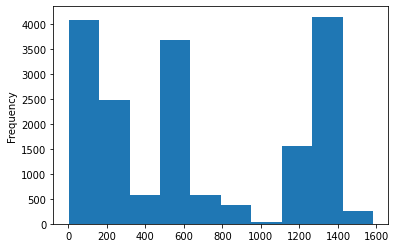

In [ ]:
data.Length.plot.hist()

In [ ]:
dataset = data[(data.Length>1000) & (data.Species.str.contains('coronavirus'))].copy()

In [ ]:
# dataset = data[(data.Length>400) & (data.Species.str.contains('coronavirus'))].copy()

In [ ]:
dataset['Label'] = dataset.Host.apply(lambda x: 1 if x=='Homo sapiens' else 0)

In [ ]:
# dataset.to_csv(FILELOC + 'species_dataset_2021110.csv')

In [ ]:
# with open(FILELOC + 'species_dataset_2021110_data.csv', 'w') as f:
#     csv.writer(f).writerows(dataset.Seq.values)
# np.savetxt(FILELOC + 'species_dataset_2021110_labels.csv', dataset.Label.values)

In [ ]:
# !pip install biopython
# import os
# import sys
# import Bio
# #Installing MAFFT using apt-get in quiet mode
# !apt-get install -qq -y mafft
# #Checking that MAFFT was succesfully installed
# !mafft --help

In [ ]:
# with open(DIR + "dataset_seq.fasta", "w") as f:
#     for ind in tqdm(dataset.index):
#         f.write(">"+dataset.loc[ind]['SeqID']+'\n')
#         f.write(dataset.loc[ind]['Seq']+'\n')

In [ ]:
# from Bio.Align.Applications import MafftCommandline
# mafft_cline=MafftCommandline(input=DIR + "dataset_seq.fasta")
# print(mafft_cline)
# stdout, stderr = mafft_cline()
# with open(DIR + "aligned_dataset.fasta", "w") as handle:
#   handle.write(stdout)
# # from Bio import AlignIO
# # align = AlignIO.read("aligned_basic.fasta", "fasta")

In [ ]:
# fasta_out = {}
# with open(DIR + 'aligned_dataset.fasta') as f:
#     for line in tqdm(f):
#         if line[0] == ">":
#             seqid = line[1:].strip('\n')
#             fasta_out[seqid] = ''
#         else:
#             fasta_out[seqid] += line.strip('\n')

# aligndf = pd.DataFrame.from_dict({'SeqID':fasta_out.keys(), 'Seq':fasta_out.values()})

In [ ]:
def f(x):
    if x=='Alphacoronavirus':
        return 0
    if x=='Betacoronavirus':
        return 1
    if x=='Gammacoronavirus':
        return 2

dataset['genuslabel'] = dataset.Genus.apply(f)

In [ ]:
# dataset.to_csv(FILELOC + 'species_dataset_2021110.csv')
# np.savetxt(FILELOC + 'species_dataset_2021110_genuslabels.csv', dataset.genuslabel.values)

In [ ]:
dataset['date'] = dataset['Release_Date'].apply(lambda x:dateparse(x))
dataset['date'] = dataset['date'].dt.date

In [ ]:
len(dataset[dataset.Collection_Date.isna()])

1138

In [ ]:
# dataset.to_csv(FILELOC + 'species_dataset_2021111.csv')

In [ ]:
# np.savetxt(FILELOC + 'species_dataset_2021111_genuslabels.csv', dataset.genuslabel.values)
# with open(FILELOC + 'species_dataset_2021111_data.csv', 'w') as f:
#     csv.writer(f).writerows(dataset.Seq.values)
# np.savetxt(FILELOC + 'species_dataset_2021111_labels.csv', dataset.Label.values)

In [ ]:
SEQLEN = 1500

def f(x):
    if len(x) < SEQLEN:
        return x + '*'*(SEQLEN-len(x))
    elif len(x) > SEQLEN:
        return x[:SEQLEN]
    else:
        return x

dataset['PadSeq'] = dataset['Seq'].apply(f)

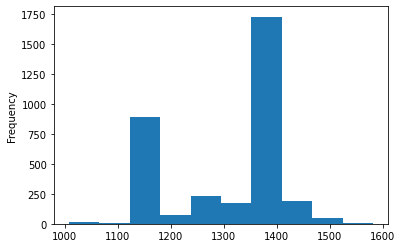

In [ ]:
dataset.Seq.apply(len).plot.hist()

###Add deltacoronavirus sequences

In [ ]:
DIR = FILELOC + 'coronavirus_spike/'

In [ ]:
fasta_out = {}
with open(DIR + 'delta_sequences_basic.fasta') as f:
    for line in tqdm(f):
        if line[0] == ">":
            seqid = line[1:].strip('\n')
            fasta_out[seqid] = ''
        else:
            fasta_out[seqid] += line.strip('\n')

fastadf = pd.DataFrame.from_dict({'SeqID':fasta_out.keys(), 'Seq':fasta_out.values()})

0it [00:00, ?it/s]

In [ ]:
fastadf['Accession'] = fastadf['SeqID'].apply(lambda x: x.split()[0].strip())

In [ ]:
metadf = pd.read_csv(DIR + 'delta_sequences_all_withoutversion.csv')

In [ ]:
fastadf.Accession = fastadf.Accession.apply(lambda x:x.split('.')[0])

In [ ]:
data = pd.merge(metadf, fastadf, on='Accession')
print(len(metadf), len(fastadf), len(data))

307 307 307


In [ ]:
dataset = data[(data.Length>1000) & (data.Species.str.contains('coronavirus|Coronavirus'))].copy()
print(len(dataset))

300


In [ ]:
# dataset = data[(data.Length>400) & (data.Species.str.contains('coronavirus|Coronavirus'))].copy()

In [ ]:
dataset['Label'] = dataset.Host.apply(lambda x: 1 if x=='Homo sapiens' else 0)

In [ ]:
def f(x):
    if x=='Alphacoronavirus':
        return 0
    if x=='Betacoronavirus':
        return 1
    if x=='Gammacoronavirus':
        return 2
    if x=='Deltacoronavirus':
        return 3

dataset['genuslabel'] = dataset.Genus.apply(f)

In [ ]:
dataset['date'] = dataset['Release_Date'].apply(lambda x:dateparse(x))
dataset['date'] = dataset['date'].dt.date

In [ ]:
len(dataset[dataset.Collection_Date.isna()])

5

In [ ]:
original = pd.read_csv(FILELOC + 'species_dataset_2021111.csv')
original.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
combdf = pd.concat([original,dataset], axis=0)

In [ ]:
# combdf.to_csv(FILELOC + 'species_dataset_20211127.csv', index=False)

In [ ]:
reduced = pd.read_csv(FILELOC + 'species_dataset_reduced_20211121.csv')
reduced.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
combdf = pd.concat([reduced,dataset], axis=0)

In [ ]:
# combdf.to_csv(FILELOC + "species_dataset_reduced_20211127.csv", index=False)

###Create spike alignments for omicron

In [ ]:
DIR = FILELOC + 'coronavirus_spike/'

In [ ]:
!pip install scikit-bio
import skbio
from skbio import TabularMSA, DNA, Protein
from skbio.alignment import local_pairwise_align_ssw

In [ ]:
seqs = [seq for seq in skbio.io.read(DIR+'gisaid_hcov-19_2021_11_28_08.fasta', format='fasta')]
spike = DNA.read(DIR+'EPI_ISL_402124-S.fasta')  # reference sequence from NCBI
align = [local_pairwise_align_ssw(DNA(seq),spike) for seq in seqs]
# align is a triplet of (alignment, score, start_end_positions)

In [ ]:
# spike.translate()
spike_prot = ''.join([x.decode() for x in spike.translate().values])

In [ ]:
# find aligned spike sequences without degenerates to translate
no_degenerates = [k for k in range(len(seqs)) if not align[k][0][0].has_degenerates()]
omicron_protein_seqs = [align[k][0][0].degap().translate() for k in no_degenerates]
omicron_seqs = [''.join([x.decode() for x in seq.values]) for seq in omicron_protein_seqs]
omicron_metadata = [seq.metadata['id'] for seq in omicron_protein_seqs]

In [ ]:
omicrondf = pd.DataFrame.from_dict({'Metadata':omicron_metadata})
omicrondf['SeqID'] = omicrondf.Metadata.apply(lambda x:x.split('|')[1])
omicrondf['Spike'] = omicron_seqs

In [ ]:
# omicrondf.to_csv(FILELOC + 'omicron_spike_20211128.csv',index=False)

##Prepare immune resistance dataset

Aligned Sequences

In [ ]:
# with open(FILELOC + 'Spike1001_allseqs_reldate.pkl', 'rb') as f:
#     alignseqs = pickle.load(f)
# with open(FILELOC + 'Spike1001_allseqs_reldate_metadata.pkl', 'rb') as f:
#     aligndf = pickle.load(f)
# print(len(aligndf))
# aligndf.drop(aligndf[aligndf.Lineage.isna()].index, inplace=True)
# print(len(aligndf))
# adf = aligndf.groupby('MaskedSeq')['Lineage'].apply(lambda x: x.value_counts().index[0]).to_frame()
# adfm = adf.join(alignseqs, how='left')
# with open(FILELOC + 'aligned_sequence_lineages_1001.pkl', 'wb') as f:
#     pickle.dump([adf, adfm], f)

with open(FILELOC + 'aligned_sequence_lineages_1001.pkl', 'rb') as f:
    adf, adfm = pickle.load(f)

Raw Sequences

In [ ]:
# rawseqs = pd.read_csv(FILELOC + 'RawSequence1001_RelDate.csv')
# with open(FILELOC + 'RawSequence_Metadata_1001.pkl', 'rb') as f:
#     rawdf = pickle.load(f)
# print(len(rawdf))
# rawdf.drop(rawdf[rawdf.Lineage.isna()].index, inplace=True)
# print(len(rawdf))
# rdf = rawdf.groupby('Spike')['Lineage'].apply(lambda x: x.value_counts().index[0]).to_frame()
# rsdf = rawseqs.set_index('Spike', drop=True)
# rdfm = rdf.join(rsdf, how='left')
# with open(FILELOC + 'raw_sequence_lineages_1001.pkl', 'wb') as f:
#     pickle.dump([rdf, rdfm], f)

with open(FILELOC + 'raw_sequence_lineages_1001.pkl', 'rb') as f:
    rdf, rdfm = pickle.load(f)

Cromer D, Steain M, Reynaldi A, Schlub TE, Wheatley AK, Juno JA, Kent SJ, Triccas JA, Khoury DS, Davenport MP. Neutralising antibody titres as predictors of protection against SARS-CoV-2 variants and the impact of boosting: a meta-analysis. Lancet Microbe. 2021 Nov 15. doi: 10.1016/S2666-5247(21)00267-6. Epub ahead of print. PMID: 34806056; PMCID: PMC8592563.

https://pubmed.ncbi.nlm.nih.gov/34806056/

"The neutralising activity against the ancestral SARS-CoV-2 was highly predictive of neutralisation of variants of concern. Decreases in neutralisation titre to the alpha (1·6-fold), beta (8·8-fold), gamma (3·5-fold), and delta (3·9-fold) variants (compared to the ancestral virus) were not significantly different between different vaccines."

Arora, P., Kempf, A., Nehlmeier, I. et al. Delta variant (B.1.617.2) sublineages do not show increased neutralization resistance. Cell Mol Immunol 18, 2557–2559 (2021). https://doi.org/10.1038/s41423-021-00772-y

In [ ]:
### Lineage -> Neutralization mapping

lins = ['A', 'B.1.1.7', 'B.1.351', 'P.1', 'B.1.617.2']
neutr = [1, 1/1.6, 1/8.8, 1/3.5, 1/3.9]
assert len(lins) == len(neutr)
numlins = len(lins)

labelmap = {lins[k]:neutr[k] for k in range(numlins)}

## B.1.640 Dataset

In [ ]:
!pip install scikit-bio
import skbio
from skbio import TabularMSA, DNA, Protein
from skbio.alignment import local_pairwise_align_ssw
!pip install biopython
from Bio.Align import substitution_matrices
import itertools

In the code below, OMICRONFILE can be any specific dataset (this was taken from the code used to obtain the Omicron spike sequences)

In [ ]:
DIR = FILELOC + 'coronavirus_spike/'
SPIKEFILE = DIR + 'EPI_ISL_402124-S.fasta'
OMICRONFILE = DIR + 'gisaid_hcov-19_2022_01_07_21_B.1.640.fasta'

seqs = [seq for seq in skbio.io.read(OMICRONFILE, format='fasta')]
spike = DNA.read(SPIKEFILE)  # reference sequence from NCBI
align = [local_pairwise_align_ssw(DNA(seq),spike) for seq in seqs]
# align is a triplet of (alignment, score, start_end_positions)
spike_prot = ''.join([x.decode() for x in spike.translate().values])

# find aligned spike sequences without degenerates to translate
no_degenerates = [k for k in range(len(seqs)) if not align[k][0][0].has_degenerates()]
omicron_protein_seqs = [align[k][0][0].degap().translate() for k in no_degenerates]
omicron_seqs = [''.join([x.decode() for x in seq.values]) for seq in omicron_protein_seqs]
omicron_metadata = [seq.metadata['id'] for seq in omicron_protein_seqs]

# find aligned spike sequences without degenerates to translate
no_degenerates = [k for k in range(len(seqs)) if not align[k][0][0].has_degenerates()]
spikelocs = [align[k][2][0] for k in range(len(seqs))]
omicron_spike_seqs = [seqs[k][spikelocs[k][0]:spikelocs[k][1]+1] for k in no_degenerates]
omicron_protein_seqs = [DNA(seq).translate() for seq in omicron_spike_seqs]
omicron_seqs = [''.join([x.decode() for x in seq.values]) for seq in omicron_protein_seqs]
omicron_metadata = [seq.metadata['id'] for seq in omicron_protein_seqs]

In [ ]:
omicrondf = pd.DataFrame.from_dict({'Metadata':omicron_metadata})
omicrondf['SeqID'] = omicrondf.Metadata.apply(lambda x:x.split('|')[1])
omicrondf['Raw'] = omicron_seqs
omicrondf['seqlen'] = omicrondf['Raw'].apply(len)

# # generate modified aligned sequences where there are insertions relative to
# # reference sequence, i.e., where the inserted residues are deleted

blosum62 = substitution_matrices.load("BLOSUM62")
def f(x):
    alignment,score,startend = local_pairwise_align_ssw(Protein(x),
                                                        Protein(spike_prot),
                                                        substitution_matrix=blosum62)
    seqalign = ''.join([x.decode() for x in alignment[0].values])
    refalign = ''.join([x.decode() for x in alignment[1].values])
    return (seqalign, refalign)

alignments = omicrondf['Raw'].apply(f).tolist()
omicrondf['seqalign'] = [a[0] for a in alignments]
omicrondf['refalign'] = [a[1] for a in alignments]

def f(x):
    seqalign, refalign = x
    try:
        if '-' in seqalign: # gap in aligned reference sequence indicates insertion
            gaps = [0 if c == '-' else 1 for c in refalign]
            return ('').join(itertools.compress(seqalign, gaps))
        else:
            return seqalign
    except:
        print('Error')
        return np.nan

# also remove stopcodons
MAXLEN = 1273
def remstop(x):
    if x[-1] == '*' and len(x) > MAXLEN:
        return x[:-1]
    else:
        return x
omicrondf['Align'] = omicrondf[['seqalign','refalign']].apply(f, axis=1).apply(remstop)

omicrondf.to_csv(FILELOC + 'B1640_spike_20220107.csv',index=False)
print(len(omicrondf))

#Load cross-validation output

In [ ]:
data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
data.reset_index(drop=True, inplace=True)

In [ ]:
train_index_list = []; test_index_list = []
train_labels_list = []; test_labels_list = []
train_predict_list = []; test_predict_list = []

for fold in tqdm(range(10)):
    train_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TrainIndex_'+str(fold)+'.csv', dtype='i')
    test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
    train_index_list.append(train_index)
    test_index_list.append(test_index)

    train_labels_list.append(data.loc[train_index]['Label'].values)
    test_labels_list.append(data.loc[test_index]['Label'].values)
    pred = np.loadtxt(FILELOC + 'covid_newpatient_output/covid_patient_crossval_20211001_predict_'+str(fold)+'.csv')
    train_predict_list.append(pred[train_index])
    test_predict_list.append(pred[test_index])

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
for fold in range(10):
    print(fold,
          mean_squared_error(train_labels_list[fold], train_predict_list[fold]),
          np.sqrt(mean_squared_error(test_labels_list[fold], test_predict_list[fold])),
          np.sqrt(mean_squared_error(test_labels_list[fold], np.mean(train_labels_list[fold])*np.ones(len(test_labels_list[fold]))))
          )

0 0.014638042230325044 0.3139640916609181 0.33004959332636913
1 0.014895349535692779 0.34497391324343424 0.2971476132486225
2 0.012205553933830781 0.3441414695162451 0.3306383144403651
3 0.009035614463175728 0.3467450902640182 0.3377550571062478
4 0.01512524239340003 0.30797196999688636 0.3456063164946015
5 0.015713130225866217 0.33105579123557455 0.3430189319652821
6 0.011228193564955096 0.33255374081796013 0.363040634449386
7 0.013227983584382522 0.3356880046993152 0.359428105632646
8 0.013675567825118714 0.3097147075583797 0.3265607025365889
9 0.014458072489585418 0.31494888333001947 0.3291354305407129


In [ ]:
print('Mean RMSE using Attention NN model =',
      np.mean(np.sqrt(mean_squared_error(test_labels_list[fold], test_predict_list[fold]))))
print('Mean RMSE guessing average of train data =',
      np.mean(np.sqrt(mean_squared_error(test_labels_list[fold], np.mean(train_labels_list[fold])*np.ones(len(test_labels_list[fold]))))))

Mean RMSE using Attention NN model = 0.31494888333001947
Mean RMSE guessing average of train data = 0.3291354305407129


####Compare to Pango

In [ ]:
data["Pango"] = data['ISM'].apply(lambda x: metadf[metadf.ISM==x]['Lineage'].value_counts().index[0])

In [ ]:
# traincounts = []; testcounts = []
# for fold in range(10):
#     TrainD = data.loc[train_index_list[fold]]; TestD = data.loc[test_index_list[fold]]
#     traincounts.append(TrainD.Pango.value_counts().rename("TrainCount_"+str(fold)))
#     testcounts.append(TestD.Pango.value_counts().rename("TestCount_"+str(fold)))
# cdf = pd.concat([pd.concat(traincounts, axis=1), pd.concat(testcounts, axis=1)], axis=1)
# for fold in range(10):
#     cdf['Train'+str(fold)] = cdf['TrainCount_'+str(fold)].values / np.sum(cdf['TrainCount_'+str(fold)])
#     cdf['Test'+str(fold)] = cdf['TestCount_'+str(fold)].values / np.sum(cdf['TestCount_'+str(fold)])

In [ ]:
pango_pred_list = []
for fold in tqdm(range(10)):
    TrainD = data.loc[train_index_list[fold]]; TestD = data.loc[test_index_list[fold]]
    D = pd.concat([TrainD.groupby("Pango")["Count"].apply(list).rename('Count_List'),
                TrainD.groupby("Pango")["Label"].apply(list).rename('Label_List')], axis=1)
    def f(x):
        count = x[0]; label = x[1]
        sumcount = sum(count)
        return sum([count[k]*label[k] for k in range(len(count))])/sumcount
    D['Label'] = D[['Count_List', 'Label_List']].apply(f, axis=1)
    def f(x):
        if x not in D.index:
            return np.nan
        else:
            return D.loc[x]['Label']
    TestD['PangoLabel'] = TestD['Pango'].apply(f)
    pango_pred_list.append(TestD[['ISM','Label','PangoLabel']])

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print('Fold ||| Pango method ||| Pango Fail% ||| Att model')
for fold in range(10):
    p = pango_pred_list[fold]
    rmse = np.sqrt(np.mean(np.square(p.Label-p.PangoLabel)))
    numfail = len(p[p.PangoLabel.isna()])
    print(fold, '|||', rmse, '|||', numfail/len(p), '|||',
          np.sqrt(mean_squared_error(test_labels_list[fold], test_predict_list[fold])))

Fold ||| Pango method ||| Pango Fail% ||| Att model
0 ||| 0.28557799342544277 ||| 0.1111111111111111 ||| 0.3139640916609181
1 ||| 0.2873916183919723 ||| 0.18055555555555555 ||| 0.34497391324343424
2 ||| 0.24061959907753575 ||| 0.1111111111111111 ||| 0.3441414695162451
3 ||| 0.2949019260956681 ||| 0.08333333333333333 ||| 0.3467450902640182
4 ||| 0.3237821921275679 ||| 0.1388888888888889 ||| 0.30797196999688636
5 ||| 0.3166423306898398 ||| 0.20833333333333334 ||| 0.33105579123557455
6 ||| 0.31485349054991807 ||| 0.09859154929577464 ||| 0.33255374081796013
7 ||| 0.3289824370770587 ||| 0.1267605633802817 ||| 0.3356880046993152
8 ||| 0.24993468797497856 ||| 0.11267605633802817 ||| 0.3097147075583797
9 ||| 0.28303041568697423 ||| 0.09859154929577464 ||| 0.31494888333001947


####Compare to Age

In [ ]:
bins = [0,20,30,40,50,60,70,80,150]
cats = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']

age_pred_list = []
for fold in tqdm(range(10)):
    TrainD = data.loc[train_index_list[fold]]; TestD = data.loc[test_index_list[fold]]
    age_train = metadf[(metadf.ISM.isin(TrainD.ISM)) & (metadf.Age != -1)][['Age', 'Label']]
    a = age_train.groupby([pd.cut(age_train['Age'], bins=bins, labels=cats),
                        'Label']).size().to_frame().rename(columns={0:'Count'})
    agebin_dict = {cat:{} for cat in cats}
    for ind, count in a.to_dict()['Count'].items():
        cat, label = ind
        agebin_dict[cat][label] = count
    agehist = pd.DataFrame.from_dict(agebin_dict, orient='index')
    agehist['Label'] = agehist[[0,1]].apply(lambda x: x[1]/(x[1]+x[0]), axis=1)
    agehist['Bin'] = range(0,len(agehist))

    def f(x):
        h,_ = np.histogram(metadf[(metadf.ISM==x) & (metadf.Age!=-1)]['Age'], bins)
        return np.sum(np.multiply(h, agehist['Label'].values)) / np.sum(h)
    TestD['AgeLabel'] = TestD['ISM'].apply(f)
    TestD['MeanAge'] = TestD['ISM'].apply(lambda x: np.mean(metadf[(metadf.ISM==x) & (metadf.Age!=-1)]['Age']))

    TestD['Pred'] = test_predict_list[fold]

    age_pred_list.append(TestD[['ISM', 'Label', 'Pred', 'AgeLabel', 'MeanAge']])

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
agermse = []; attrmse = []

print('Fold ||| Age bins ||| Age Fail% ||| Att model')
for fold in range(10):
    p = age_pred_list[fold]
    agermse.append(np.sqrt(np.mean(np.square(p.Label-p.AgeLabel))))
    attrmse.append(np.sqrt(mean_squared_error(test_labels_list[fold], test_predict_list[fold])))
    numfail = len(p[p.AgeLabel.isna()])
    print(f"{fold:4} ||| {agermse[fold]:.6f} ||| {numfail/len(p):9.4f} ||| {attrmse[fold]:.6f}")

Fold ||| Age bins ||| Age Fail% ||| Att model
   0 ||| 0.321584 |||    0.0139 ||| 0.313964
   1 ||| 0.300181 |||    0.0000 ||| 0.344974
   2 ||| 0.316685 |||    0.0000 ||| 0.344141
   3 ||| 0.321668 |||    0.0000 ||| 0.346745
   4 ||| 0.331458 |||    0.0000 ||| 0.307972
   5 ||| 0.327358 |||    0.0139 ||| 0.331056
   6 ||| 0.351997 |||    0.0000 ||| 0.332554
   7 ||| 0.351957 |||    0.0000 ||| 0.335688
   8 ||| 0.307848 |||    0.0282 ||| 0.309715
   9 ||| 0.308229 |||    0.0000 ||| 0.314949


In [ ]:
# for fold in range(10):
#     a = age_pred_list[fold].copy()
#     a['roundlabel'] = np.round(a['Label'])
#     a.hist(column='MeanAge', by='roundlabel')

In [ ]:
print('Age', np.mean(agermse), np.std(agermse))
print('Attention', np.mean(attrmse), np.std(attrmse))

Age 0.32389644477707796 0.0166553189306232
Attention 0.32817576623227507 0.014462787928849058


####Mass Output

In [ ]:
DC_Pred = {}; DC_Pred['NoAdj_Folds'] = {}; DC_Pred['AgeAdj_Folds'] = {}

data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
data.reset_index(drop=True, inplace=True)
train_index_list = []; test_index_list = []
train_labels_list = []; test_labels_list = []

for fold in range(10):
    train_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TrainIndex_'+str(fold)+'.csv', dtype='i')
    test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
    train_index_list.append(train_index)
    test_index_list.append(test_index)
    train_labels_list.append(data.loc[train_index]['Label'].values)
    test_labels_list.append(data.loc[test_index]['Label'].values)
    DC_Pred['NoAdj_Folds'][fold] = np.sqrt(mean_squared_error(test_labels_list[fold],
                                                              np.mean(train_labels_list[fold])*np.ones(len(test_labels_list[fold]))))

DC_Pred['NoAdj_Mean'] = np.mean([np.sqrt(mean_squared_error(test_labels_list[fold], np.mean(train_labels_list[fold])*np.ones(len(test_labels_list[fold])))) for fold in range(10)])
DC_Pred['NoAdj_Std'] = np.std([np.sqrt(mean_squared_error(test_labels_list[fold], np.mean(train_labels_list[fold])*np.ones(len(test_labels_list[fold])))) for fold in range(10)])
print("Average-DC Pred Ave/StDev")
print(DC_Pred['NoAdj_Mean'])
print(DC_Pred['NoAdj_Std'])

data = pd.read_csv(FILELOC + 'covid_agepatient_crossval/covid_agepatient_alldata_20211003.csv')
data.reset_index(drop=True, inplace=True)
train_index_list = []; test_index_list = []
train_labels_list = []; test_labels_list = []

for fold in range(10):
    train_index = np.loadtxt(FILELOC + 'covid_agepatient_crossval/TrainIndex_'+str(fold)+'.csv', dtype='i')
    test_index = np.loadtxt(FILELOC + 'covid_agepatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
    train_index_list.append(train_index)
    test_index_list.append(test_index)
    train_labels_list.append(data.loc[train_index]['AdjLabel'].values)
    test_labels_list.append(data.loc[test_index]['AdjLabel'].values)
    DC_Pred['AgeAdj_Folds'][fold] = np.sqrt(mean_squared_error(test_labels_list[fold],
                                                               np.mean(train_labels_list[fold])*np.ones(len(test_labels_list[fold]))))

DC_Pred['AgeAdj_Mean'] = np.mean([np.sqrt(mean_squared_error(test_labels_list[fold], np.mean(train_labels_list[fold])*np.ones(len(test_labels_list[fold])))) for fold in range(10)])
DC_Pred['AgeAdj_Std'] = np.std([np.sqrt(mean_squared_error(test_labels_list[fold], np.mean(train_labels_list[fold])*np.ones(len(test_labels_list[fold])))) for fold in range(10)])

print("Average-DC Pred Ave/StDev")
print(DC_Pred['AgeAdj_Mean'])
print(DC_Pred['AgeAdj_Std'])


Average-DC Pred Ave/StDev
0.33623806997408223
0.017703157453326755
Average-DC Pred Ave/StDev
0.3375733576959363
0.017873983613175763


In [ ]:
def mass_analysis(outdir, numruns):

    pat_folds = {}; age_folds = {}

    data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
    data.reset_index(drop=True, inplace=True)
    for run in range(1,numruns+1):
        train_index_list = []; test_index_list = []
        train_labels_list = []; test_labels_list = []
        train_predict_list = []; test_predict_list = []
        pat_folds[run] = {}
        for fold in range(10):
            try:
                pred = np.loadtxt(FILELOC+outdir+'/covid_patient_crossval_20211003_'+str(run)+'_predict_'+str(fold)+'.csv')
            except:
                try:
                    pred = np.loadtxt(FILELOC+outdir+'/covid_patient_crossval_20211004_'+str(run)+'_predict_'+str(fold)+'.csv')
                except:
                    try:
                        pred = np.loadtxt(FILELOC+outdir+'/covid_patient_crossval_20211006_'+str(run)+'_predict_'+str(fold)+'.csv')
                    except:
                        pat_folds[run][fold] = np.nan
                        continue
            train_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TrainIndex_'+str(fold)+'.csv', dtype='i')
            test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
            train_index_list.append(train_index)
            test_index_list.append(test_index)
            train_labels_list.append(data.loc[train_index]['Label'].values)
            test_labels_list.append(data.loc[test_index]['Label'].values)

            train_predict_list.append(pred[train_index])
            test_predict_list.append(pred[test_index])
            pat_folds[run][fold] = np.sqrt(mean_squared_error(test_labels_list[-1],
                                                              test_predict_list[-1]))
        if len(test_predict_list) < 10:
            print("NoAdj: there were", len(test_predict_list), "valid folds in", outdir, "run", run)
        pat_ave = np.mean([np.sqrt(mean_squared_error(test_labels_list[fold],
                                                      test_predict_list[fold])) for fold in range(len(test_predict_list))])
        pat_std = np.std([np.sqrt(mean_squared_error(test_labels_list[fold],
                                                     test_predict_list[fold])) for fold in range(len(test_predict_list))])

    # Age Adjusted

    data = pd.read_csv(FILELOC + 'covid_agepatient_crossval/covid_agepatient_alldata_20211003.csv')
    data.reset_index(drop=True, inplace=True)
    for run in range(1,numruns+1):
        train_index_list = []; test_index_list = []
        train_labels_list = []; test_labels_list = []
        train_predict_list = []; test_predict_list = []
        age_folds[run] = {}
        for fold in range(10):
            try:
                pred = np.loadtxt(FILELOC + outdir + '/covid_agepatient_crossval_20211003_'+str(run)+'_predict_'+str(fold)+'.csv')
            except:
                try:
                    pred = np.loadtxt(FILELOC + outdir + '/covid_agepatient_crossval_20211004_'+str(run)+'_predict_'+str(fold)+'.csv')
                except:
                    try:
                        pred = np.loadtxt(FILELOC+outdir+'/covid_agepatient_crossval_20211006_'+str(run)+'_predict_'+str(fold)+'.csv')
                    except:
                        age_folds[run][fold] = np.nan
                        continue
            train_index = np.loadtxt(FILELOC + 'covid_agepatient_crossval/TrainIndex_'+str(fold)+'.csv', dtype='i')
            test_index = np.loadtxt(FILELOC + 'covid_agepatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
            train_index_list.append(train_index)
            test_index_list.append(test_index)
            train_labels_list.append(data.loc[train_index]['AdjLabel'].values)
            test_labels_list.append(data.loc[test_index]['AdjLabel'].values)

            train_predict_list.append(pred[train_index])
            test_predict_list.append(pred[test_index])
            age_folds[run][fold] = np.sqrt(mean_squared_error(test_labels_list[-1],
                                                              test_predict_list[-1]))
        if len(test_predict_list) < 10:
            print("AgeAdj: there were", len(test_predict_list), "valid folds in", outdir, "run", run)
        age_ave = np.mean([np.sqrt(mean_squared_error(test_labels_list[fold],
                                                      test_predict_list[fold])) for fold in range(len(test_predict_list))])
        age_std = np.std([np.sqrt(mean_squared_error(test_labels_list[fold],
                                                     test_predict_list[fold])) for fold in range(len(test_predict_list))])

    return pat_ave, pat_std, age_ave, age_std, pat_folds, age_folds


These results might have the wrong # of dense neurons (i.e. 32 each time regardless of Nh)

defaults is W = 3, dropout = 0.2, learn rate = 0.01 (1e-2), Nc = 128

scratch1 – results with dropout
scratch2 – results no dropout
scratch3 – results with W=6 
scratch4 – results with learn rate 0.001 (1e-3)
scratch5 – results with learn rate 0.0001 (1e-4)
scratch6 – results with W = 6 and L.R. = 1e-4
scratch7 – resutls with W = 1 and L.R. = 1e-4
scratch8 – results with W=1, Nc=1024, L.R. = 1e-4 scratch9 – results with W=1, Nc=512, L.R. = 1e-4 scratch10 – results with W=1, Nc=1273, L.R.=1e-4

covidout1: ENC_DIM = 50
N_H = 32
DROP_RATE = 0.2
LEARN_RATE = 0.0001
NUM_EPOCHS = 300
PATIENCE = 20
covidout2: same as covidout1 but PATIENCE = 100
covidout3: same as covidout1 but ENC_DIM = 10
covidout4: same as covidout3 but PATIENCE = 100

covidout5: ENC_DIM=100
N_H=64
DROP_RATE=0.0
LEARN_RATE=0.0001
NUM_EPOCHS=300
PATIENCE=100
covidout6: same as covidout5 but PATIENCE=40
covidout7: same as covidout6 but DROP_RATE=0.2

covidout8: ENC_DIM=100
N_H=256
DROP_RATE=0.2
LEARN_RATE=0.0001
NUM_EPOCHS=300
(PATIENCE = 40)
covidout9: same as covidout8 but PATIENCE=100
covidout10: same as covidout9 but DROP_RATE=0.0

covidout11: ENC_DIM = 100, N_H = 64, ResNet W=1, Nc=256, Nl=4, DROP_RATE= 0, LEARN_RATE = 1e-4, NUM_EPOCHS=300 (PATIENCE=100)

covidout12: same as covidout11 but W=3

covidout13: same as covidout11 but Nc = 512

covidout14: same as covidout12 but Nc = 128

covidout15: W=3, Nc=512 (double-checked for N_H dense neurons)

covidout16: W=1, Nc=512 (N_H dense neurons instead of 32 hard-coded in covidout13)

covidout17: same as covidout16 except Nc=1024



In [ ]:
Results = {}
index_names = ['NoAdj_Mean', 'NoAdj_Std', 'AgeAdj_Mean', 'AgeAdj_Std',
               'NoAdj_Folds', 'AgeAdj_Folds']

In [ ]:
for k in tqdm(range(1,11)):
    dir = 'scratch_results/scratch'+str(k)
    Results['scratch'+str(k)] = mass_analysis(dir, 3)

for k in tqdm(range(1,18)):
    dir = 'covidout_results/covidout'+str(k)
    Results['covidout'+str(k)] = mass_analysis(dir, 3)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

2 2
AgeAdj: there were 9 valid folds in covidout_results/covidout9 run 2


In [ ]:
for k in tqdm(['256', '512']):
    dir = 'covidout_results/covidout'+k
    Results['covidout'+k] = mass_analysis(dir, 5)

Results['covidout_50_64_512_results'] = mass_analysis('covidout_50_64_512_results', 5)
Results['covidout_50_64_1024_results'] = mass_analysis('covidout_50_64_1024_results', 5)
Results['covidout_slow'] = mass_analysis('covidout_slow', 5)

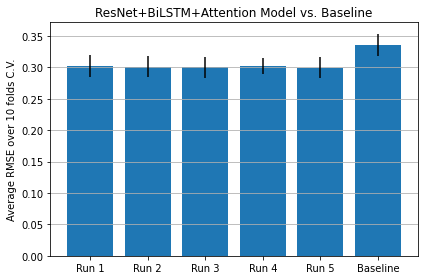

In [ ]:
MODEL = 'covidout_slow'

noadjmeans = []; noadjstds = []; adjmeans = []; adjstds = []
numruns = len(Results[MODEL][4])

for run in range(1,1+numruns):
    # print('Run', run)
    # print('NoAdj')
    # print(np.mean(([Results[MODEL][4][run][f] for f in range(10)])),
    #       np.std(([Results[MODEL][4][run][f] for f in range(10)])))
    # print('AgeAdj')
    # print(np.mean(([Results[MODEL][5][run][f] for f in range(10)])),
    #       np.std(([Results[MODEL][5][run][f] for f in range(10)])))
    noadjmeans.append(np.nanmean(([Results[MODEL][4][run][f] for f in range(10)])))
    noadjstds.append(np.nanstd(([Results[MODEL][4][run][f] for f in range(10)])))
    # adjmeans.append(np.nanmean(([Results[MODEL][5][run][f] for f in range(10)])))
    # adjstds.append(np.nanstd(([Results[MODEL][5][run][f] for f in range(10)])))

adjmeans.append(DC_Pred['AgeAdj_Mean'])
adjstds.append(DC_Pred['AgeAdj_Std'])
noadjmeans.append(DC_Pred['NoAdj_Mean'])
noadjstds.append(DC_Pred['NoAdj_Std'])

fig, ax = plt.subplots()
barlabels = ['Run '+str(run) for run in range(1,1+numruns)] + ['Baseline']
x_pos = range(len(barlabels))
ax.bar(x_pos, noadjmeans, yerr=noadjstds)
# ax.bar(x_pos, adjmeans, yerr=adjstds)

ax.set_xticks(x_pos)
ax.set_xticklabels(barlabels)
# ax.set_xticklabels(barlabels, rotation = 45, ha="right")
ax.set_ylabel('Average RMSE over 10 folds C.V.')
ax.set_title('ResNet+BiLSTM+Attention Model vs. Baseline')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
resultsdf = pd.DataFrame.from_dict({index_names[k]:[Results[m][k] for m in Results]
                                    for k in range(len(index_names))})
resultsdf.rename(index={ind:[m for m in Results][ind] for ind in resultsdf.index}, inplace=True)

In [ ]:
barlabels = {
    'scratch5':'One-Hot+CNN, W=3, Nc=512',
    'scratch6':'One-Hot+CNN, W=6, Nc=128',
    'scratch9':'One-Hot+CNN, W=1, Nc=512',
    'covidout2':'Embed+LSTM, dim=50, Nh=32',
    'covidout4':'Embed+LSTM, dim=10, Nh=32',
    'covidout5':'Embed+LSTM, dim=100, Nh=64',
    'covidout7':'Embed+LSTM, dim=100, Nh=64, dropout',
    'covidout9':'Embed+LSTM, dim=100, Nh=256, dropout',
    'covidout10':'Embed+LSTM, dim=100, Nh=256',
    'covidout256':'Emb+ResNet+LSTM, dim=100, W=1, Nc=256 Nh=64',
    'covidout512':'Emb+ResNet+LSTM, dim=100, W=1, Nc=512, Nh=64',
    'covidout17':'Emb+ResNet+LSTM, dim=100, W=1, Nc=1024, Nh=64',
    'covidout14':'Emb+ResNet+LSTM, dim=100, W=3, Nc=128, Nh=64',
    'covidout12':'Emb+ResNet+LSTM, dim=100, W=3, Nc=256, Nh=64',
    'covidout15':'Emb+ResNet+LSTM, dim=100, W=3, Nc=512, Nh=64',
    'covidout_50_64_512_results':'Emb+ResNet+LSTM, dim=50, W=1, Nc=512, Nh=64',
    'covidout_50_64_1024_results':'Emb+ResNet+LSTM, dim=50, W=1, Nc=1024, Nh=64',
}

In [ ]:
np.array(list(barlabels.keys()))

array(['scratch5', 'scratch6', 'scratch9', 'covidout2', 'covidout4',
       'covidout5', 'covidout7', 'covidout9', 'covidout10', 'covidout256',
       'covidout512', 'covidout17', 'covidout14', 'covidout12',
       'covidout15', 'covidout_50_64_512_results',
       'covidout_50_64_1024_results'], dtype='<U27')

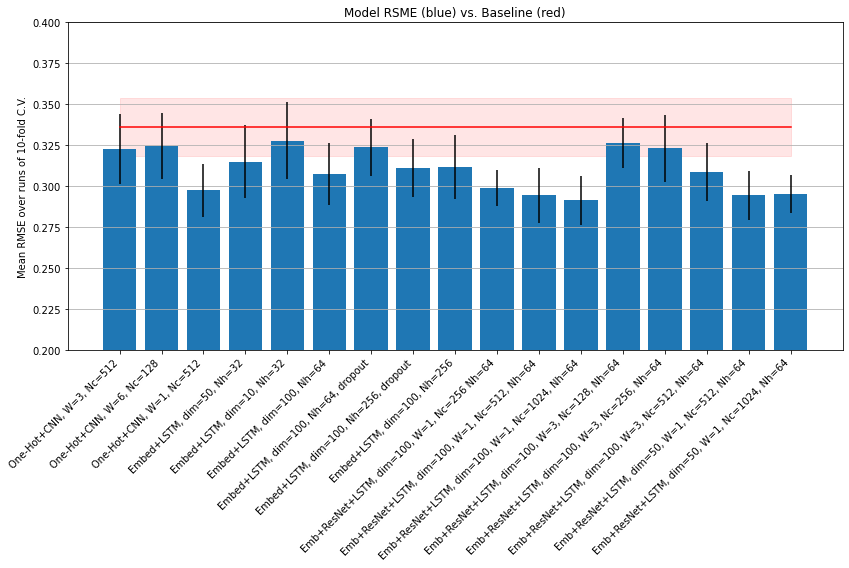

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

x_pos = range(len(barlabels))
noadjmeans = resultsdf.loc[np.array(list(barlabels.keys()))]['NoAdj_Mean'].values
noadjstds = resultsdf.loc[np.array(list(barlabels.keys()))]['NoAdj_Std'].values
ax.bar(x_pos, noadjmeans, yerr=noadjstds)
ax.set_xticks(x_pos)
ax.set_xticklabels(barlabels.values(), rotation = 45, ha="right")
ax.set_ylim([0.2,0.4])

dcmean = DC_Pred['NoAdj_Mean']*np.ones(len(x_pos))
dcstd = DC_Pred['NoAdj_Std']*np.ones(len(x_pos))
ax.plot(x_pos, dcmean, color='r')
ax.fill_between(x_pos, dcmean+dcstd, dcmean-dcstd, color='r', alpha=0.1)

ax.set_ylabel('Mean RMSE over runs of 10-fold C.V.')
ax.set_title('Model RSME (blue) vs. Baseline (red)')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

Parameter Sweeps

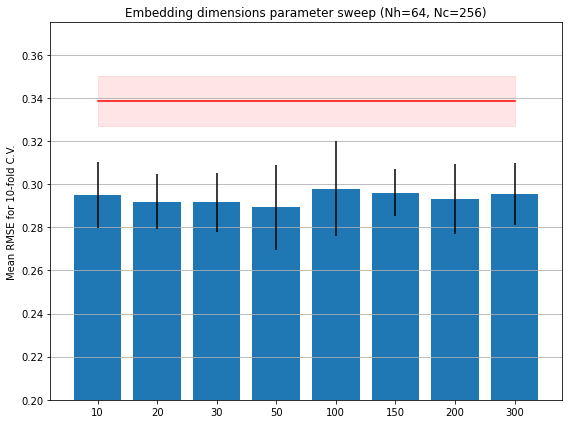

In [ ]:
data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
data.reset_index(drop=True, inplace=True)

dimlist = [10,20,30,50,100,150,200,300]
foldlist = [0,2,5,7,9]
sweep_rmse = {}
sweep_baseline_mean = np.mean([DC_Pred['NoAdj_Folds'][f] for f in foldlist])
sweep_baseline_std = np.std([DC_Pred['NoAdj_Folds'][f] for f in foldlist])

for dim in dimlist:
    sweep_rmse[dim] = []
    for fold in foldlist:
        pred = np.loadtxt(FILELOC+'covidout_noadj_nencsweep_1/'+'covid_noadj_nencsweep_20211005_predict_ne_'+str(dim)+'_fold_'+str(fold)+'.csv')
        test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
        test_pred = pred[test_index]
        test_label = data.loc[test_index]['Label'].values
        sweep_rmse[dim].append(np.sqrt(mean_squared_error(test_label, test_pred)))

sweep_means = [np.mean(sweep_rmse[d]) for d in dimlist]
sweep_stds = [np.std(sweep_rmse[d]) for d in dimlist]

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
x_pos = range(len(dimlist))
ax.bar(x_pos, sweep_means, yerr=sweep_stds)
ax.set_xticks(x_pos)
ax.set_xticklabels(dimlist)
ax.set_ylim([0.2,0.375])
dcmean = sweep_baseline_mean*np.ones(len(x_pos))
dcstd = sweep_baseline_std*np.ones(len(x_pos))
ax.plot(x_pos, dcmean, color='r')
ax.fill_between(x_pos, dcmean+dcstd, dcmean-dcstd, color='r', alpha=0.1)
ax.set_ylabel('Mean RMSE for 10-fold C.V.')
ax.set_title('Embedding dimensions parameter sweep (Nh=64, Nc=256)')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

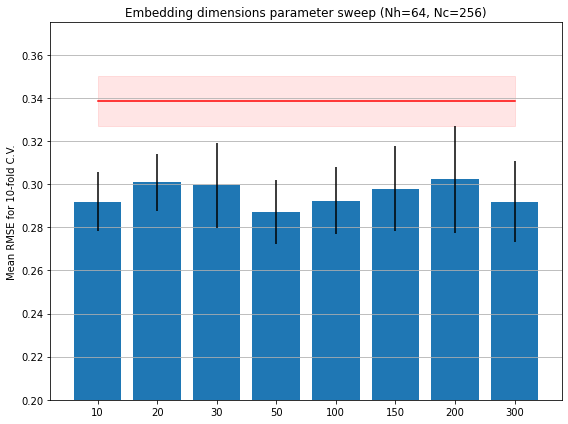

In [ ]:
data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
data.reset_index(drop=True, inplace=True)

dimlist = [10,20,30,50,100,150,200,300]
foldlist = [0,2,5,7,9]
sweep_rmse = {}
sweep_baseline_mean = np.mean([DC_Pred['NoAdj_Folds'][f] for f in foldlist])
sweep_baseline_std = np.std([DC_Pred['NoAdj_Folds'][f] for f in foldlist])

for dim in dimlist:
    sweep_rmse[dim] = []
    for fold in foldlist:
        pred = np.loadtxt(FILELOC+'covidout_noadj_nencsweep_2/'+'covid_noadj_nencsweep_20211005_predict_ne_'+str(dim)+'_fold_'+str(fold)+'.csv')
        test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
        test_pred = pred[test_index]
        test_label = data.loc[test_index]['Label'].values
        sweep_rmse[dim].append(np.sqrt(mean_squared_error(test_label, test_pred)))

sweep_means = [np.mean(sweep_rmse[d]) for d in dimlist]
sweep_stds = [np.std(sweep_rmse[d]) for d in dimlist]

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
x_pos = range(len(dimlist))
ax.bar(x_pos, sweep_means, yerr=sweep_stds)
ax.set_xticks(x_pos)
ax.set_xticklabels(dimlist)
ax.set_ylim([0.2,0.375])
dcmean = sweep_baseline_mean*np.ones(len(x_pos))
dcstd = sweep_baseline_std*np.ones(len(x_pos))
ax.plot(x_pos, dcmean, color='r')
ax.fill_between(x_pos, dcmean+dcstd, dcmean-dcstd, color='r', alpha=0.1)
ax.set_ylabel('Mean RMSE for 10-fold C.V.')
ax.set_title('Embedding dimensions parameter sweep (Nh=64, Nc=256)')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

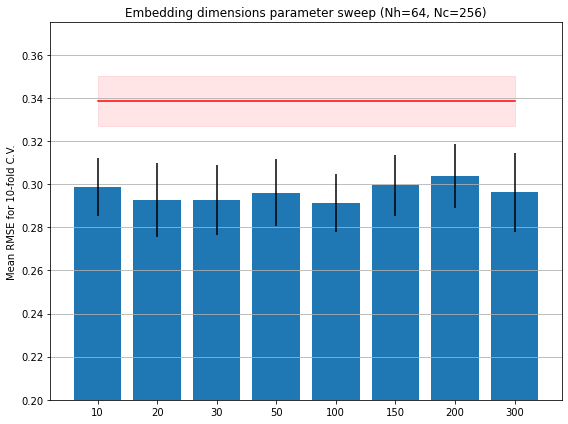

In [ ]:
data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
data.reset_index(drop=True, inplace=True)

dimlist = [10,20,30,50,100,150,200,300]
foldlist = [0,2,5,7,9]
sweep_rmse = {}
sweep_baseline_mean = np.mean([DC_Pred['NoAdj_Folds'][f] for f in foldlist])
sweep_baseline_std = np.std([DC_Pred['NoAdj_Folds'][f] for f in foldlist])

for dim in dimlist:
    sweep_rmse[dim] = []
    for fold in foldlist:
        pred = np.loadtxt(FILELOC+'covidout_noadj_nencsweep_3/'+'covid_noadj_nencsweep_20211005_predict_ne_'+str(dim)+'_fold_'+str(fold)+'.csv')
        test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
        test_pred = pred[test_index]
        test_label = data.loc[test_index]['Label'].values
        sweep_rmse[dim].append(np.sqrt(mean_squared_error(test_label, test_pred)))

sweep_means = [np.mean(sweep_rmse[d]) for d in dimlist]
sweep_stds = [np.std(sweep_rmse[d]) for d in dimlist]

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
x_pos = range(len(dimlist))
ax.bar(x_pos, sweep_means, yerr=sweep_stds)
ax.set_xticks(x_pos)
ax.set_xticklabels(dimlist)
ax.set_ylim([0.2,0.375])
dcmean = sweep_baseline_mean*np.ones(len(x_pos))
dcstd = sweep_baseline_std*np.ones(len(x_pos))
ax.plot(x_pos, dcmean, color='r')
ax.fill_between(x_pos, dcmean+dcstd, dcmean-dcstd, color='r', alpha=0.1)
ax.set_ylabel('Mean RMSE for 10-fold C.V.')
ax.set_title('Embedding dimensions parameter sweep (Nh=64, Nc=256)')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

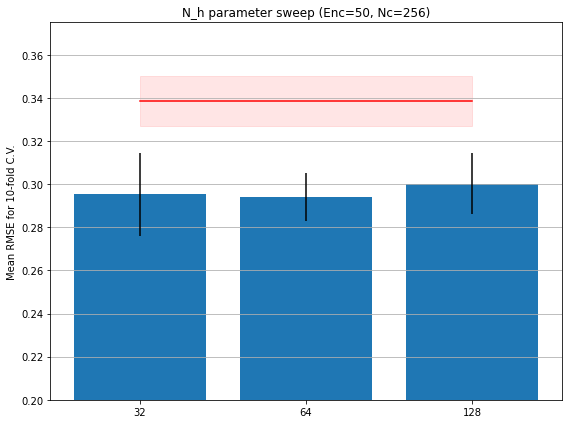

In [ ]:
data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
data.reset_index(drop=True, inplace=True)

dimlist = [32,64,128]
foldlist = [0,2,5,7,9]
sweep_rmse = {}
sweep_baseline_mean = np.mean([DC_Pred['NoAdj_Folds'][f] for f in foldlist])
sweep_baseline_std = np.std([DC_Pred['NoAdj_Folds'][f] for f in foldlist])

for dim in dimlist:
    sweep_rmse[dim] = []
    for fold in foldlist:
        pred = np.loadtxt(FILELOC+'covidout_noadj_nhsweep_1/'+'covid_noadj_nhsweep_20211005_predict_nh_'+str(dim)+'_fold_'+str(fold)+'.csv')
        test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
        test_pred = pred[test_index]
        test_label = data.loc[test_index]['Label'].values
        sweep_rmse[dim].append(np.sqrt(mean_squared_error(test_label, test_pred)))

sweep_means = [np.mean(sweep_rmse[d]) for d in dimlist]
sweep_stds = [np.std(sweep_rmse[d]) for d in dimlist]

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
x_pos = range(len(dimlist))
ax.bar(x_pos, sweep_means, yerr=sweep_stds)
ax.set_xticks(x_pos)
ax.set_xticklabels(dimlist)
ax.set_ylim([0.2,0.375])
dcmean = sweep_baseline_mean*np.ones(len(x_pos))
dcstd = sweep_baseline_std*np.ones(len(x_pos))
ax.plot(x_pos, dcmean, color='r')
ax.fill_between(x_pos, dcmean+dcstd, dcmean-dcstd, color='r', alpha=0.1)
ax.set_ylabel('Mean RMSE for 10-fold C.V.')
ax.set_title('N_h parameter sweep (Enc=50, Nc=256)')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

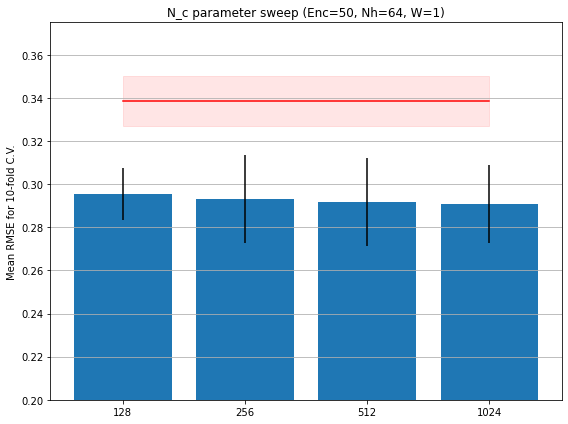

In [ ]:
data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
data.reset_index(drop=True, inplace=True)

dimlist = [128,256,512,1024]
foldlist = [0,2,5,7,9]
sweep_rmse = {}
sweep_baseline_mean = np.mean([DC_Pred['NoAdj_Folds'][f] for f in foldlist])
sweep_baseline_std = np.std([DC_Pred['NoAdj_Folds'][f] for f in foldlist])

for dim in dimlist:
    sweep_rmse[dim] = []
    for fold in foldlist:
        pred = np.loadtxt(FILELOC+'covidout_noadj_ncsweep_1/'+'covid_noadj_ncsweep_20211005_predict_nc_'+str(dim)+'_fold_'+str(fold)+'.csv')
        test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
        test_pred = pred[test_index]
        test_label = data.loc[test_index]['Label'].values
        sweep_rmse[dim].append(np.sqrt(mean_squared_error(test_label, test_pred)))

sweep_means = [np.mean(sweep_rmse[d]) for d in dimlist]
sweep_stds = [np.std(sweep_rmse[d]) for d in dimlist]

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
x_pos = range(len(dimlist))
ax.bar(x_pos, sweep_means, yerr=sweep_stds)
ax.set_xticks(x_pos)
ax.set_xticklabels(dimlist)
ax.set_ylim([0.2,0.375])
dcmean = sweep_baseline_mean*np.ones(len(x_pos))
dcstd = sweep_baseline_std*np.ones(len(x_pos))
ax.plot(x_pos, dcmean, color='r')
ax.fill_between(x_pos, dcmean+dcstd, dcmean-dcstd, color='r', alpha=0.1)
ax.set_ylabel('Mean RMSE for 10-fold C.V.')
ax.set_title('N_c parameter sweep (Enc=50, Nh=64, W=1)')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

#####Bookmark

No handles with labels found to put in legend.


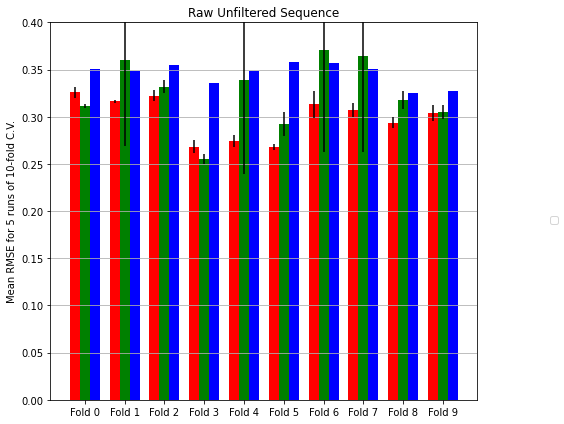

In [ ]:
data = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
data.reset_index(drop=True, inplace=True)

test_predict_list = {}; rmse_list = {}
tpl_trans = {}; rmse_trans = {}

for run in range(1,6):
    test_predict_list[run] = []; rmse_list[run] = []
    tpl_trans[run] = []; rmse_trans[run] = []
    for fold in range(10):
        test_index = np.loadtxt(FILELOC + 'covid_rawseqs_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
        pred = np.loadtxt(FILELOC + 'covidout_rawseqs/covid_rawseqs_crossval_20211010_'+str(run)+'_predict_'+str(fold)+'.csv')
        test_predict_list[run].append(pred[test_index])
        rmse = np.sqrt(mean_squared_error(data.loc[test_index]['Label'], pred[test_index]))
        rmse_list[run].append(rmse)
        pred = np.loadtxt(FILELOC + 'covidout_trans_rawseqs/covid_rawseqs_crossval_20211013_'+str(run)+'_predict_'+str(fold)+'.csv')
        tpl_trans[run].append(pred[test_index])
        rmse = np.sqrt(mean_squared_error(data.loc[test_index]['Label'], pred[test_index]))
        rmse_trans[run].append(rmse)

DC_pred = []; DC_rmse_list = []
for fold in range(10):
    train_index = np.loadtxt(FILELOC + 'covid_rawseqs_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
    test_index = np.loadtxt(FILELOC + 'covid_rawseqs_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
    dc_pred = np.mean(data.loc[train_index]['Label'])
    rmse = np.sqrt(mean_squared_error(data.loc[test_index]['Label'], dc_pred*np.ones(len(test_index))))
    DC_rmse_list.append(rmse)

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
x_pos = np.linspace(0,9,10)
width = 0.25
ax.bar(x_pos, [np.mean([rmse_list[r][f] for r in range(1,6)]) for f in range(10)],
       width, yerr = [np.std([rmse_list[r][f] for r in range(1,6)]) for f in range(10)],
       color='r')
ax.bar(x_pos+width, [np.mean([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)],
       width, yerr = [np.std([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)],
       color='g')
ax.set_xticks(x_pos+width)
ax.set_xticklabels([('Fold '+str(f)) for f in range(10)])
ax.set_ylim([0,0.4])
ax.bar(x_pos+2*width, DC_rmse_list, width, color='b')
ax.set_ylabel('Mean RMSE for 5 runs of 10-fold C.V.')
ax.set_title('Raw Unfiltered Sequence')
ax.yaxis.grid(True)
ax.legend(bbox_to_anchor=(1.2, 0.5))
plt.tight_layout()
plt.show()

rawseq_rmse_mean = np.mean([np.mean([rmse_list[r][f] for r in range(1,6)]) for f in range(10)])
rawseq_rmse_std = np.std([np.mean([rmse_list[r][f] for r in range(1,6)]) for f in range(10)])
rawseq_trans_rmse_mean = np.mean([np.mean([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)])
rawseq_trans_rmse_std = np.std([np.mean([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)])
rawseq_dc_mean = np.mean(DC_rmse_list)
rawseq_dc_std = np.std(DC_rmse_list)

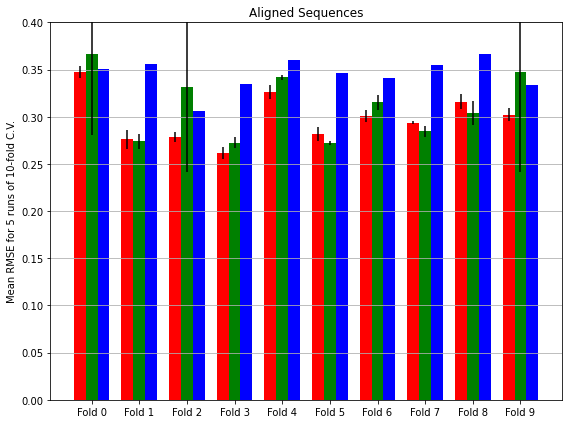

In [ ]:
data = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
data.reset_index(drop=True, inplace=True)

test_predict_list = {}; rmse_list = {}
tpl_trans = {}; rmse_trans = {}

for run in range(1,6):
    test_predict_list[run] = []; rmse_list[run] = []
    tpl_trans[run] = []; rmse_trans[run] = []
    for fold in range(10):
        test_index = np.loadtxt(FILELOC + 'covid_aligned_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
        pred = np.loadtxt(FILELOC + 'covidout_aligned/covid_aligned_crossval_20211010_'+str(run)+'_predict_'+str(fold)+'.csv')
        test_predict_list[run].append(pred[test_index])
        rmse = np.sqrt(mean_squared_error(data.loc[test_index]['Label'], pred[test_index]))
        rmse_list[run].append(rmse)
        pred = np.loadtxt(FILELOC + 'covidout_trans_aligned/covid_aligned_crossval_20211013_'+str(run)+'_predict_'+str(fold)+'.csv')
        tpl_trans[run].append(pred[test_index])
        rmse = np.sqrt(mean_squared_error(data.loc[test_index]['Label'], pred[test_index]))
        rmse_trans[run].append(rmse)

DC_pred = []; DC_rmse_list = []
for fold in range(10):
    train_index = np.loadtxt(FILELOC + 'covid_aligned_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
    test_index = np.loadtxt(FILELOC + 'covid_aligned_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
    dc_pred = np.mean(data.loc[train_index]['Label'])
    rmse = np.sqrt(mean_squared_error(data.loc[test_index]['Label'], dc_pred*np.ones(len(test_index))))
    DC_rmse_list.append(rmse)

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
x_pos = np.linspace(0,9,10)
width = 0.25
ax.bar(x_pos, [np.mean([rmse_list[r][f] for r in range(1,6)]) for f in range(10)],
       width, yerr = [np.std([rmse_list[r][f] for r in range(1,6)]) for f in range(10)],
       color='r')
ax.bar(x_pos+width, [np.mean([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)],
       width, yerr = [np.std([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)],
       color='g')
ax.set_xticks(x_pos+width)
ax.set_xticklabels([('Fold '+str(f)) for f in range(10)])
ax.set_ylim([0,0.4])
ax.bar(x_pos+2*width, DC_rmse_list, width, color='b')
ax.set_ylabel('Mean RMSE for 5 runs of 10-fold C.V.')
ax.set_title('Aligned Sequences')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

aligned_rmse_mean = np.mean([np.mean([rmse_list[r][f] for r in range(1,6)]) for f in range(10)])
aligned_rmse_std = np.std([np.mean([rmse_list[r][f] for r in range(1,6)]) for f in range(10)])
aligned_trans_rmse_mean = np.mean([np.mean([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)])
aligned_trans_rmse_std = np.std([np.mean([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)])
aligned_dc_mean = np.mean(DC_rmse_list)
aligned_dc_std = np.std(DC_rmse_list)

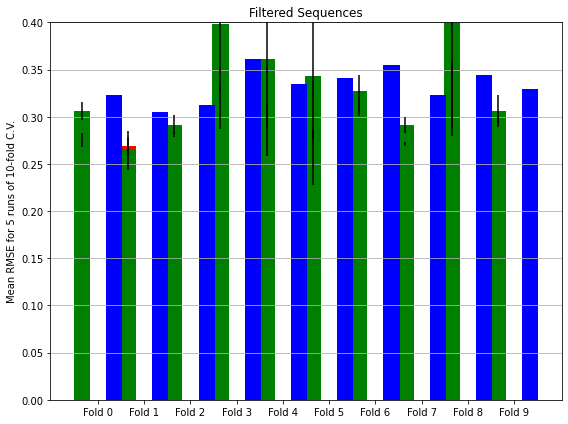

In [ ]:
data = pd.read_csv(FILELOC + 'covid_filtered_crossval/covid_patient_0912_filtered_sequences.csv')
data.reset_index(drop=True, inplace=True)
tpl_trans = {}; rmse_trans = {}

test_predict_list = {}; rmse_list = {}

for run in range(1,6):
    test_predict_list[run] = []; rmse_list[run] = []
    tpl_trans[run] = []; rmse_trans[run] = []
    for fold in range(10):
        test_index = np.loadtxt(FILELOC + 'covid_filtered_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
        pred = np.loadtxt(FILELOC + 'covidout_filtered/covid_filtered_crossval_20211010_'+str(run)+'_predict_'+str(fold)+'.csv')
        test_predict_list[run].append(pred[test_index])
        rmse = np.sqrt(mean_squared_error(data.loc[test_index]['Label'], pred[test_index]))
        rmse_list[run].append(rmse)
        pred = np.loadtxt(FILELOC + 'covidout_trans_filtered/covid_filtered_crossval_20211013_'+str(run)+'_predict_'+str(fold)+'.csv')
        tpl_trans[run].append(pred[test_index])
        rmse = np.sqrt(mean_squared_error(data.loc[test_index]['Label'], pred[test_index]))
        rmse_trans[run].append(rmse)

DC_pred = []; DC_rmse_list = []
for fold in range(10):
    train_index = np.loadtxt(FILELOC + 'covid_filtered_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
    test_index = np.loadtxt(FILELOC + 'covid_filtered_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
    dc_pred = np.mean(data.loc[train_index]['Label'])
    rmse = np.sqrt(mean_squared_error(data.loc[test_index]['Label'], dc_pred*np.ones(len(test_index))))
    DC_rmse_list.append(rmse)

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
x_pos = np.linspace(0,9,10)
width = 0.25
ax.bar(x_pos, [np.mean([rmse_list[r][f] for r in range(1,6)]) for f in range(10)],
       width, yerr = [np.std([rmse_list[r][f] for r in range(1,6)]) for f in range(10)],
       color='r')
ax.bar(x_pos+width, [np.mean([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)],
       width, yerr = [np.std([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)],
       color='g')
ax.set_xticks(x_pos+width)
ax.set_xticklabels([('Fold '+str(f)) for f in range(10)])
ax.set_ylim([0,0.4])
ax.bar(x_pos+2*width, DC_rmse_list, width, color='b')
ax.set_ylabel('Mean RMSE for 5 runs of 10-fold C.V.')
ax.set_title('Filtered Sequences')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

filtered_rmse_mean = np.mean([np.mean([rmse_list[r][f] for r in range(1,6)]) for f in range(10)])
filtered_rmse_std = np.std([np.mean([rmse_list[r][f] for r in range(1,6)]) for f in range(10)])
filtered_trans_rmse_mean = np.mean([np.mean([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)])
filtered_trans_rmse_std = np.std([np.mean([rmse_trans[r][f] for r in range(1,6)]) for f in range(10)])
filtered_dc_mean = np.mean(DC_rmse_list)
filtered_dc_std = np.std(DC_rmse_list)

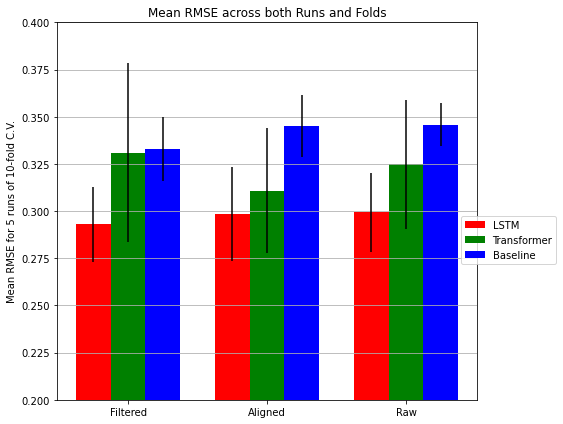

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
x_pos = np.linspace(0,2,3)
width = 0.25
ax.bar(x_pos, [filtered_rmse_mean, aligned_rmse_mean, rawseq_rmse_mean],
       width, yerr = [filtered_rmse_std, aligned_rmse_std, rawseq_rmse_std],
       label='LSTM', color='r')
ax.bar(x_pos+width, [filtered_trans_rmse_mean, aligned_trans_rmse_mean, rawseq_trans_rmse_mean],
       width, yerr = [filtered_trans_rmse_std, aligned_trans_rmse_std, rawseq_trans_rmse_std],
       label='Transformer',color='g')
ax.set_xticks(x_pos+width)
ax.set_xticklabels(['Filtered', 'Aligned', 'Raw'])
ax.set_ylim([0.2,0.4])
ax.bar(x_pos+2*width, [filtered_dc_mean, aligned_dc_mean, rawseq_dc_mean],
       width, yerr = [filtered_dc_std, aligned_dc_std, rawseq_dc_std],
       label='Baseline', color='b')
ax.set_ylabel('Mean RMSE for 5 runs of 10-fold C.V.')
ax.set_title('Mean RMSE across both Runs and Folds')
ax.yaxis.grid(True)
ax.legend(bbox_to_anchor=(1.2, 0.5))
plt.tight_layout()
plt.show()

###Analyze embeddings

In [ ]:
EMBEDFILES = 'covid_attmodel_16/covid_patient_crossval_20211004_1_embedding_'

In [ ]:
embed_list = {}

for fold in range(10):
    embed_list[fold] = pd.read_csv(FILELOC+EMBEDFILES+str(fold)+'.csv', header=None).to_numpy()

In [ ]:
FOLD = 9
embed = embed_list[FOLD]

train_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TrainIndex_'+str(FOLD)+'.csv', dtype='i')
test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(FOLD)+'.csv', dtype='i')

In [ ]:
# d = data.loc[train_index_list[2]]
# td = TSNE(n_components=2).fit_transform(np.vstack(d['Embedding_2']))

In [ ]:
t = TSNE(n_components=2, perplexity=30, init='pca', verbose=1).fit_transform(embed)
# t = TSNE(n_components=3, perplexity=50, init='pca', verbose=1).fit_transform(embed)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 716 samples in 0.004s...
[t-SNE] Computed neighbors for 716 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 716 / 716
[t-SNE] Mean sigma: 0.005421
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.431496
[t-SNE] KL divergence after 1000 iterations: 0.278014


In [ ]:
# pangocats = metadf.Lineage.value_counts().index[:10]
pangocats = ['B.1.429', 'B.1.617.2|AY.20', 'B.1.526', 'B.1.1|B.1|B.1.177',
             'P.1', 'A', 'B.1.1.7']
cladecats = metadf.Clade.value_counts().index
# cladecats = ['GRY', 'O', 'S', 'L']

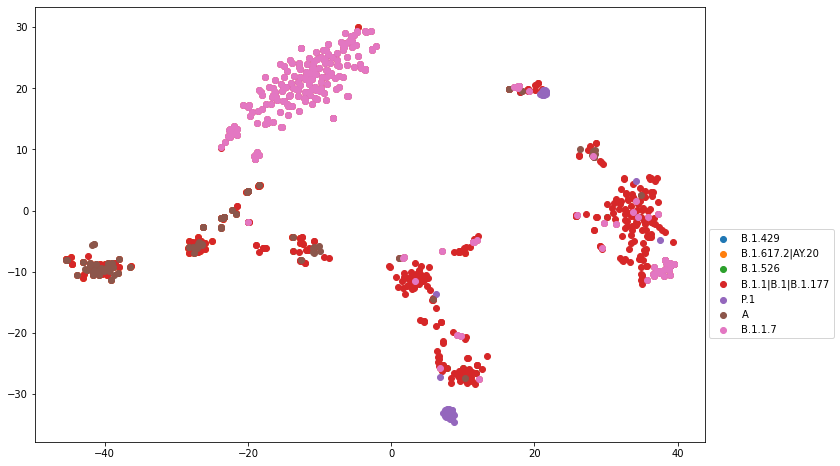

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

for pl in pangocats:
    selind = data[data.ISM.isin(metadf[metadf.Lineage.str.match(pl)]['ISM'])].index
    ax.scatter(t[selind,0], t[selind,1], label=pl)  

ax.legend(bbox_to_anchor=(1.2, 0.5))
plt.show()

In [ ]:
# pca = PCA(n_components=3)
# p = pca.fit_transform(embed)

In [ ]:
# fig, ax = plt.subplots()
# # fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
# fig.set_size_inches(10,6)

# for pl in pangocats:
#     selind = data[data.ISM.isin(metadf[metadf.Lineage.str.match(pl)]['ISM'])].index
#     ax.scatter(p[selind,0], p[selind,1], label=pl)  

# plt.legend()
# plt.show()

In [ ]:
# svd = TruncatedSVD(n_components=256, n_iter=10, random_state=42)
# s = svd.fit_transform(data_enc)

In [ ]:
# stsne = TSNE(n_components=2, perplexity=50, init='pca', verbose=1).fit_transform(s)

In [ ]:
# fig, ax = plt.subplots()
# # fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
# fig.set_size_inches(12,8)

# selind = data[(data.index.isin(test_index_list[8])) & (data.Label < 0.5)].index
# ax.scatter(stsne[selind,0], stsne[selind,1], label="Mild (< 0.5)", marker = 'x')
# selind = data[(data.index.isin(test_index_list[8])) & (data.Label > 0.5)].index
# ax.scatter(stsne[selind,0], stsne[selind,1], label="Severe (> 0.5)", marker = 'o', alpha=0.2)

# ax.legend(bbox_to_anchor=(1.2, 0.5))
# plt.show()

In [ ]:
# centers = KMeans(n_clusters=12, random_state=0).fit_predict(s)
# D["Cluster"] = centers
# m = {}
# for n in set(D.Cluster):
#     m[n] = M[M.ISM.isin(D[D.Cluster==n]['ISM'])]
# for a in range(len(m)):
#     print(a, len(m[a]), len(D[D.Cluster==a]))
# for n in range(len(m)):
#     print("Cluster", n)
#     print(m[n].Lineage.value_counts())

###Evaluate Attention

In [ ]:
ATTFILES = 'covidout_50_64_512_results/covid_patient_crossval_20211006_2_attention_'

In [ ]:
att_list = {}

for fold in range(10):
    att_list[fold] = pd.read_csv(FILELOC+ATTFILES+str(fold)+'.csv', header=None).to_numpy()

In [ ]:
train_index_list = []; test_index_list = []
for fold in range(10):
    train_index_list.append(np.loadtxt(FILELOC + 'covid_newpatient_crossval/TrainIndex_'+str(fold)+'.csv', dtype='i'))
    test_index_list.append(np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i'))

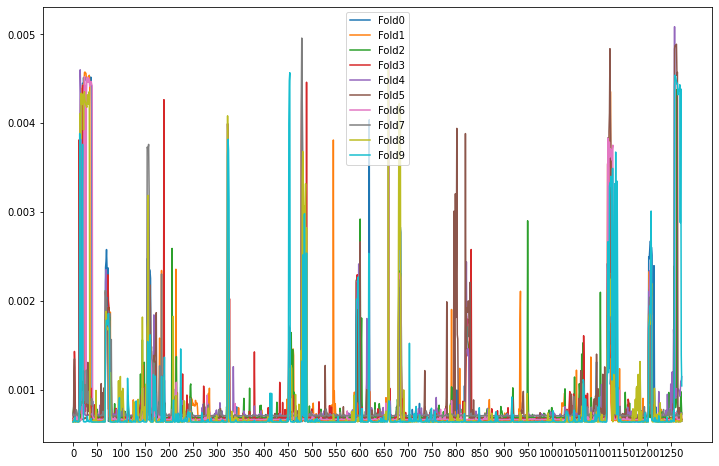

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(12,8)
for fold in range(10):
    ax.plot(np.mean(att_list[fold][test_index_list[fold]], axis=0), label='Fold'+str(fold))
ax.set_xticks(range(0,1300,50))
plt.legend()
plt.show()

In [ ]:
ind = data[data.ISM.isin(metadf[metadf.Lineage=='B.1.617.2']['ISM'])].index
att = att_list[9][ind]

m = np.mean(att, axis=0)[400:800]
s = np.std(att, axis=0)[400:800]
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.plot(range(len(m)), m)
ax.fill_between(range(len(m)), m+s, m-s, alpha=0.5)

ax.set_xticks(range(0,len(m),20))
ax.set_xticklabels([str(k) for k in range(400,800,20)])

plt.show()

In [ ]:
from IPython.display import HTML
def  hlstr(string, color='white'):
    """
    Return HTML markup highlighting text with the desired color.
    """
    return f"<mark style=background-color:{color}>{string} </mark>"

def colorize(attrs, cmap='PiYG'):
    """
    Compute hex colors based on the attributions for a single instance.
    Uses a diverging colorscale by default and normalizes and scales
    the colormap so that colors are consistent with the attributions.
    """
    import matplotlib as mpl
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))
    return colors

In [ ]:
# ind = data[data.ISM.isin(metadf[metadf.Lineage=='B.1.617.2']['ISM'])].index
# att = att_list[9][ind]

ind = data[data.Label < 0.5].index
att = att_list[9][ind]


In [ ]:
ismlen = 1273
THRESH = 1/ismlen
colors = colorize(np.mean(att, axis=0) - THRESH)

ismlist = list(range(ismlen))
ismlist_text = ' '.join([str(x) for x in np.add(1,ismlist)])
# print(ismlist_text)
HTML("".join(list(map(hlstr, ismlist_text.split(), colors))))

In [ ]:
ind = data[data.Label > 0.5].index
att = att_list[9][ind]

colors = colorize(np.mean(att, axis=0) - THRESH)
HTML("".join(list(map(hlstr, ismlist_text.split(), colors))))

###Get Weights for Embedding Layer

##XGBoost

In [ ]:
def xgb_analysis(outdir, md, lr):

    data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
    data.reset_index(drop=True, inplace=True)
    rmse = {}
    for fold in range(10):
        pred = np.loadtxt(FILELOC+outdir+'/covid_pat_XGB_crossval_predict_20211006_21468_'+str(md)+'_'+str(lr)+'_'+str(fold)+'.csv')
        test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')
        test_labels = (data.loc[test_index]['Label'].values)
        test_pred = pred[test_index]
        rmse[fold] = np.sqrt(mean_squared_error(test_labels, test_pred))
    mean_rmse = np.mean([rmse[fold] for fold in range(10)])
    std_rmse = np.std([rmse[fold] for fold in range(10)])
    
    return rmse, mean_rmse, std_rmse

In [ ]:
adjmeans

[0.2961268068727841,
 0.29818553820780824,
 0.293245787592492,
 0.2976417293131283,
 0.2902333386109716,
 0.3375733576959363]

  0%|          | 0/6 [00:00<?, ?it/s]

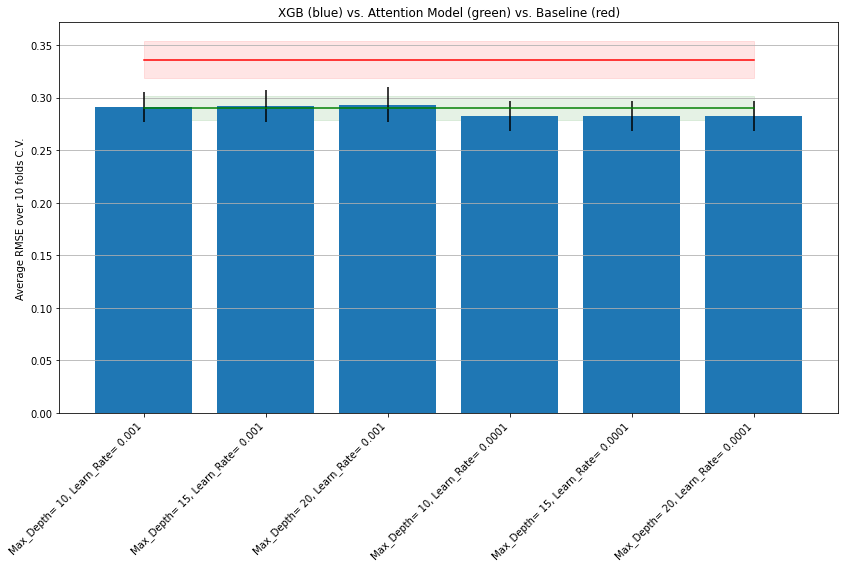

In [ ]:
xgb_results = {}
dir = 'covidout_xgb'
md_lr = [(10,0.001), (15,0.001), (20,0.001), (10,0.0001), (15,0.0001), (20,0.0001)]
paramlist = []
for md, lr in tqdm(md_lr):
    par = 'Max_Depth= '+str(md)+', Learn_Rate= '+str(lr)
    xgb_results[par] = xgb_analysis(dir, md, lr)
    paramlist.append(par)

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
barlabels = paramlist
x_pos = range(len(barlabels))
ax.bar(x_pos, [xgb_results[p][1] for p in paramlist], yerr=[xgb_results[p][2] for p in paramlist])
# ax.bar(x_pos, adjmeans, yerr=adjstds)

dcmean = DC_Pred['NoAdj_Mean']*np.ones(len(x_pos))
dcstd = DC_Pred['NoAdj_Std']*np.ones(len(x_pos))
ax.plot(x_pos, dcmean, color='r')
ax.fill_between(x_pos, dcmean+dcstd, dcmean-dcstd, color='r', alpha=0.1)

# nnmean = np.mean(adjmeans[:-1])*np.ones(len(x_pos))
# nnstd = np.std(adjstds[:-1])*np.ones(len(x_pos))
nnmean = adjmeans[4]*np.ones(len(x_pos))
nnstd = adjstds[4]*np.ones(len(x_pos))
ax.plot(x_pos, nnmean, color='g')
ax.fill_between(x_pos, nnmean+nnstd, nnmean-nnstd, color='g', alpha=0.1)

ax.set_xticks(x_pos)
ax.set_xticklabels(barlabels, rotation = 45, ha="right")
ax.set_ylabel('Average RMSE over 10 folds C.V.')
ax.set_title('XGB (blue) vs. Attention Model (green) vs. Baseline (red)')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
data = pd.read_csv(FILELOC + 'covid_newpatient_crossval/covid_newpatient_alldata_20210930.csv')
data.reset_index(drop=True, inplace=True)
# aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E',
#           'G', 'H', 'I', 'L', 'K', 'M', 'F',
#           'P', 'S', 'T', 'W', 'Y', 'V', '-',
#           ]
# aa_tokenizer = {aa_list[k]:k for k in range(len(aa_list))}

ism_array = np.vstack(data['ISM'].apply(lambda x: np.array(list(x))))
numseqs, ismlen = np.shape(ism_array)
labels = data.Label.values

enc = OneHotEncoder()
ism_array_enc = enc.fit_transform(ism_array)
feature_names = enc.get_feature_names(list(map(str,list(range(1,ismlen+1)))))

train_index_list = []; test_index_list = []
train_data_list = []; test_data_list = []
train_labels_list = []; test_labels_list = []
train_predict_list = []; test_predict_list = []
feature_shap_train = []; feature_shap_test = []

for fold in tqdm(range(10)):
    train_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TrainIndex_'+str(fold)+'.csv', dtype='i')
    test_index = np.loadtxt(FILELOC + 'covid_newpatient_crossval/TestIndex_'+str(fold)+'.csv', dtype='i')

    y_train = labels[train_index].ravel()
    y_test = labels[test_index].ravel()
    x_train_enc = ism_array_enc[train_index]
    x_test_enc = ism_array_enc[test_index]

    train_index_list.append(train_index); test_index_list.append(test_index)
    test_data_list.append(x_test_enc)
    train_labels_list.append(y_train); test_labels_list.append(y_test)

    xgbst = xgb.Booster()
    xgbst.load_model(FILELOC + "covid_xgb_crossval_weights/covid_patient_XGB_crossval_model_20211001_" + str(fold) + ".bin")

    TrainD = xgb.DMatrix(x_train_enc.toarray(), np.array(y_train), feature_names=feature_names)
    TestD = xgb.DMatrix(x_test_enc.toarray(), np.array(y_test), feature_names=feature_names)

    pred_train = xgbst.predict(TrainD)
    pred_test = xgbst.predict(TestD)
    shap_test = xgbst.predict(TestD, pred_contribs=True)

    train_predict_list.append(pred_train)
    test_predict_list.append(pred_test)
    # feature_shap_train.append(shap_train)
    feature_shap_test.append(shap_test)

    print('Train MSE =', np.mean(np.square(y_train - pred_train)),
          'Test RMSE =', np.sqrt(np.mean(np.square(y_test - pred_test))))


  0%|          | 0/10 [00:00<?, ?it/s]

Train MSE = 0.19379156424426364 Test RMSE = 0.414576325329772
Train MSE = 0.1490801263653553 Test RMSE = 0.3646042910878866
Train MSE = 0.3187942252869371 Test RMSE = 0.5549838413285572
Train MSE = 0.14687841115289998 Test RMSE = 0.3276023346149908
Train MSE = 0.2020200580550849 Test RMSE = 0.46587807423830974
Train MSE = 0.17033812923750818 Test RMSE = 0.4268007353711205
Train MSE = 0.15890453260528162 Test RMSE = 0.4061464988940574
Train MSE = 0.19518757333475656 Test RMSE = 0.5053491591353312
Train MSE = 0.18551579281420083 Test RMSE = 0.4231919719704513
Train MSE = 0.1601680220971252 Test RMSE = 0.42209882806688903


In [ ]:
!pip install shap
import shap

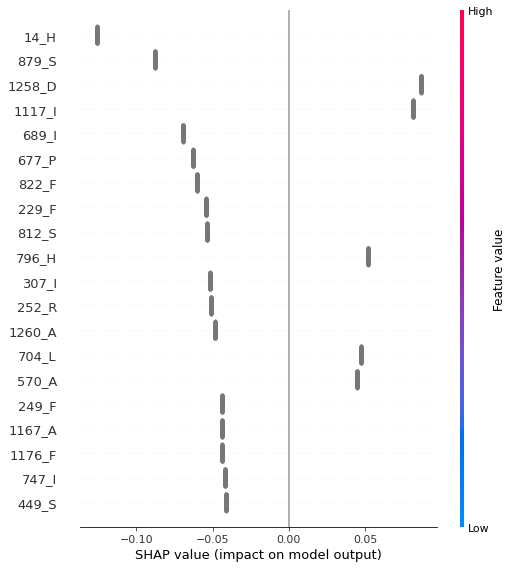

In [ ]:
shap.summary_plot(feature_shap_test[0][:,:-1], test_data_list[0], feature_names=feature_names)

#Evaluate on Validation Dataset

In [ ]:
# ENC_DIM = 50    # token embedding dimension
# N_H = 64        # number of hidden states in LSTM
# N_C = 512       # number of convolutional filters in ResNet
# DROP_RATE = 0.0
# NUM_EPOCHS = 300
# BATCH_SIZE = 48
# LEARN_RATE = 0.001

In [ ]:
def residual_block(x, n_filters, kernel_size):

    y = keras.layers.Conv1D(kernel_size=kernel_size,
                            strides=1,
                            filters=n_filters,
                            padding="same",
                            activation="relu",
                            )(x)
    # y = keras.layers.ReLU()(y)
    y = keras.layers.BatchNormalization()(y)

    y = keras.layers.Conv1D(kernel_size=kernel_size,
                            strides=1,
                            filters=n_filters,
                            padding="same",
                            )(y)

    out = keras.layers.Add()([x, y])
    out = keras.layers.ReLU()(out)
    out = keras.layers.BatchNormalization()(out)

    return out

def create_ResNet(x, n_layers, n_filters, kernel_size):

    y = keras.layers.Conv1D(filters = n_filters,
                            kernel_size = kernel_size,
                            strides = 1,
                            padding = 'same',
                            activation="relu",
                            )(x)
    # y = keras.layers.ReLU(y)
    y = keras.layers.BatchNormalization()(y)
    for layer in range(n_layers):
        y = residual_block(y, n_filters, kernel_size)
    
    return y

def linear01(x):
    return tf.clip_by_value(x, clip_value_min=0, clip_value_max=1)

def AttModel(L, n_enc, Nh, vocab_size, bilstm_v_gru=True, num_outputs=1, regress=False,
             mask=True, dropout_rate=0.0,
             num_dense=False, num_dense_2=False,
             resnet=False, W=None, Nc=None, Nl=None):
    
    inputs = keras.layers.Input(shape = (L,))
    embedlayer = keras.layers.Embedding(vocab_size, n_enc, mask_zero=True,
                                        trainable=True,
                                        name='token_embedding',
                                        )(inputs)
    x = embedlayer

    if mask:
        mask = keras.layers.Masking(mask_value=0)(x)
        x = mask

    x = create_ResNet(x,
                    n_layers = Nl,
                    n_filters = Nc,
                    kernel_size = W
                    )

    # h = keras.layers.Bidirectional(keras.layers.LSTM(Nh,
    #                                                  return_sequences=True,
    #                                                  dropout=0.0,
    #                                                  ))(x)
    hf = keras.layers.LSTM(Nh, return_sequences=True)(x)
    hr = keras.layers.LSTM(Nh, return_sequences=True, go_backwards=True)(x)
    h = keras.layers.add([hf, hr])
    # h = keras.layers.concatenate([hf, hr])

    # Attention layer
    h = keras.layers.TimeDistributed(keras.layers.Dense(Nh, activation='tanh'))(h)
    attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(h)
    attention = keras.layers.Flatten()(attention)  
    attention = keras.layers.Softmax(axis=1, name='attention')(attention) # normalize attention values
    # attention = keras.layers.RepeatVector(2*Nh)(attention)
    attention = keras.layers.RepeatVector(Nh)(attention)
    attention = keras.layers.Permute([2, 1])(attention)
    representation = keras.layers.multiply([h, attention])
    representation = tf.math.reduce_sum(representation, axis = 1)
    x = representation

    if num_dense:
        x = keras.layers.Dense(num_dense, activation='relu', name='embedding')(x)
        if dropout_rate:
            x =  keras.layers.Dropout(dropout_rate)(x)

    if num_dense_2:
        x = keras.layers.Dense(num_dense_2, activation='relu')(x)
        if dropout_rate:
            x =  keras.layers.Dropout(dropout_rate)(x)

    if not regress:
        if num_outputs == 1:
            out = keras.layers.Dense(num_outputs, activation='sigmoid')(x)
        else:
            out = keras.layers.Dense(num_outputs, activation='softmax')(x)
    else:
        out = keras.layers.Dense(1, activation=linear01)(x)

    return keras.Model(inputs=inputs, outputs=out)

def reset_model(num_classes=1, tpu=False, regression=False):

    model = AttModel(L=ismlen,
                     n_enc = ENC_DIM,
                     Nh = N_H,
                     vocab_size = len(aa_list)+1,
                     bilstm_v_gru=True,
                     num_dense = N_H,
                     num_dense_2=0,
                     num_outputs=num_classes,
                     mask=True,
                     regress=regression,
                     dropout_rate = DROP_RATE,
                     resnet = True,
                     W = 1, Nc = N_C, Nl = 4,
                     )

    optimizer = keras.optimizers.Adam(learning_rate=LEARN_RATE)

    if num_classes==1:
        if regression:
            loss = keras.losses.MeanSquaredError()
            optimizer = keras.optimizers.Adam(learning_rate=LEARN_RATE)
            metrics = [keras.metrics.MeanSquaredError(name='mse'),
                       keras.metrics.MeanSquaredLogarithmicError(name='msle'),
                       keras.losses.MeanAbsoluteError(name='mae')
                       ]
        else:
            loss = keras.losses.BinaryCrossentropy(from_logits=False)
            metrics = [keras.metrics.BinaryAccuracy(name='acc'),
                    keras.metrics.AUC(name='auc'),
                    keras.metrics.Precision(name='prec'),
                    keras.metrics.Recall(name='rec'),
                    ]
    else:
        loss = keras.losses.SparseCategoricalCrossentropy()      
        metrics = [keras.metrics.SparseCategoricalAccuracy(name='accuracy')] 

    try:
        STEPS_PER_EXECUTION
    except:
        STEPS_PER_EXECUTION = 50

    if tpu:
        model.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metrics,
                    steps_per_execution = STEPS_PER_EXECUTION,
                    )
    else:
        model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics,
                )
    return model

In [ ]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, mask_zero=False):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
                                                output_dim=embed_dim,
                                                mask_zero=mask_zero)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,
                                              mask_zero=mask_zero)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def linear01(x):
    return tf.clip_by_value(x, clip_value_min=0, clip_value_max=1)

def AttModel(L, vocab_size, embdim, numheads, ffdim, num_dense=False,
             mask_zero=False, dropout_rate=False, trans_drop=0.1,
             Nt=1, W=False, Nc=False, Nl=False):

    inpTensor = keras.Input(shape=(L,))
    x = inpTensor

    if mask_zero:
        x = keras.layers.Masking(mask_value=0)(x)   

    x = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)

    if W and Nc and Nl:
        for n in range(Nl):
            x = keras.layers.Conv1D(filters = Nc,
                                kernel_size = W,
                                activation = 'relu',
                                padding = 'same',
                                )(x)
            if n > 1 and n < Nl-1:
                x = keras.layers.BatchNormalization()(x)

    for n in range(Nt):
        x = TransformerBlock(Nc, numheads, ffdim, rate=trans_drop)(x)

    # Attention layer
    h = keras.layers.TimeDistributed(keras.layers.Dense(Nc, activation='tanh'))(x)
    attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(h)
    attention = keras.layers.Flatten()(attention)  
    attention = keras.layers.Softmax(axis=1, name='attention')(attention) # normalize attention values

    # attention = keras.layers.RepeatVector(embdim)(attention)
    attention = keras.layers.RepeatVector(Nc)(attention)

    attention = keras.layers.Permute([2, 1])(attention)
    representation = keras.layers.multiply([h, attention])
    representation = tf.math.reduce_sum(representation, axis = 1)
    x = representation

    if num_dense:
        x = keras.layers.Dense(num_dense, activation = 'relu', name='embedding_dense')(x)
    if dropout_rate:
        x = keras.layers.Dropout(Params[dropout_rate])(x)

    finalOut = keras.layers.Dense(1, activation=linear01)(x)

    # define the model's start and end points    
    model = keras.Model(inpTensor,finalOut)

    return model

In [ ]:
# model_dir = FILELOC + 'covidout_trans_fulldata_2/'
# modeltype='aligned'; run=1
# aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F',
#           'P', 'S', 'T', 'W', 'Y', 'V', '-',]
# ENCDIM = 1500; NC = 300; NL = 1; NT = 1; NHEADS = 8; FFDIM = 64; NDENSE = 64
# TRANSDROPRATE = 0.1; DROPRATE = 0.0; ismlen = 1273

# model = AttModel(L=ismlen, vocab_size=len(aa_list)+1, embdim = ENCDIM,
#                     numheads = NHEADS, ffdim = FFDIM, num_dense = NDENSE,
#                     mask_zero=True, dropout_rate = DROPRATE, trans_drop = TRANSDROPRATE,
#                     Nt = NT, W = 1, Nc = NC, Nl = NL)

# model.load_weights(model_dir + 'covid_'+modeltype+'_fulldata_weights_20211013_'+str(run)+'.h5')

# model.summary()

In [ ]:
model_dir = FILELOC + 'covidout_trans_fulldata_2/'

ENCDIM = 1500; NC = 300; NL = 1; NT = 1; NHEADS = 8; FFDIM = 64; NDENSE = 64
TRANSDROPRATE = 0.1; DROPRATE = 0.0; ismlen = 1273

nruns = 5

aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F',
          'P', 'S', 'T', 'W', 'Y', 'V', '-',]
aa_tokenizer = {aa_list[k]:k+1 for k in range(len(aa_list))}
aa_tokenizer['*'] = 0
aa_tokenizer['X'] = 0
def padder(x):
    if len(x) < 1273:
        return x + '*'*(1273-len(x))
    elif len(x) > 1273:
        return x[:1273]
    else:
        return x

# Do raw labels
modeltypes = ['aligned', 'filtered', 'rawseqs']
MSE = {}
for modeltype in modeltypes:
    traindata = pd.read_csv(FILELOC + 'covid_'+modeltype+'_crossval/covid_patient_0912_'+modeltype+'.csv')
    valdata = pd.read_csv(FILELOC + 'covid_'+modeltype+'_crossval/covid_patient_0912_valid1001_'+modeltype+'.csv')
    ismlen = 1273

    train_array = np.vstack(traindata['ISM'].apply(padder).apply(lambda x: np.array(list(x))))
    val_array = np.vstack(valdata['ISM'].apply(padder).apply(lambda x: np.array(list(x))))
    train_tok = np.vectorize(aa_tokenizer.get)(train_array) 
    val_tok = np.vectorize(aa_tokenizer.get)(val_array)
    y_train = traindata['Label'].values

    MSE[modeltype] = {}

    for run in range(1, nruns+1):
        tf.keras.backend.clear_session()    # reset Tensorflow session
        with tpu_strategy.scope():
            model = AttModel(L=ismlen, vocab_size=len(aa_list)+1, embdim = ENCDIM,
                                numheads = NHEADS, ffdim = FFDIM, num_dense = NDENSE,
                                mask_zero=True, dropout_rate = DROPRATE, trans_drop = TRANSDROPRATE,
                                Nt = NT, W = 1, Nc = NC, Nl = NL)
            # model.compile(loss=keras.losses.MeanSquaredError(),
            #                 optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            #                 metrics=[keras.metrics.MeanSquaredError(name='mse')],)       
            model.load_weights(model_dir + 'covid_'+modeltype+'_fulldata_weights_20211013_'+str(run)+'.h5')

            pred = model.predict(train_tok, verbose=2).ravel()
            np.savetxt(model_dir + 'covid_traindata0912_pred_'+modeltype+'_'+str(run)+'.csv', pred, delimiter=',')
            # get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
            # att = get_attention_model.predict(train_tok, verbose=2, batch_size=32)
            # np.savetxt(model_dir + 'covid_traindata0912_att_'+modeltype+'_'+str(run)+'.csv', att, delimiter=',')
            # get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('embedding_dense').output)
            # emb = get_embedding_model.predict(train_tok, verbose=2, batch_size=32)
            # np.savetxt(model_dir + 'covid_traindata0912_emb_'+modeltype+'_'+str(run)+'.csv', emb, delimiter=',')

            # MSE[modeltype][run] = mean_squared_error(y_train, pred)

            pred = model.predict(val_tok, verbose=2).ravel()
            np.savetxt(model_dir + 'covid_valdata1001_pred_'+modeltype+'_'+str(run)+'.csv', pred, delimiter=',')
            # get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
            # att = get_attention_model.predict(val_tok, verbose=2, batch_size=32)
            # np.savetxt(model_dir + 'covid_valdata1001_att_'+modeltype+'_'+str(run)+'.csv', att, delimiter=',')
            # get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('embedding_dense').output)
            # emb = get_embedding_model.predict(val_tok, verbose=2, batch_size=32)
            # np.savetxt(model_dir + 'covid_valdata1001_emb_'+modeltype+'_'+str(run)+'.csv', emb, delimiter=',')

# with open(model_dir + 'MSE.pkl', 'wb') as f:
#     pickle.dump(MSE, f)

29/29 - 8s
594/594 - 16s
29/29 - 8s
594/594 - 16s
29/29 - 8s
594/594 - 16s
29/29 - 8s
594/594 - 16s
29/29 - 8s
594/594 - 16s
23/23 - 8s
214/214 - 5s
23/23 - 8s
214/214 - 5s
23/23 - 8s
214/214 - 5s
23/23 - 8s
214/214 - 5s
23/23 - 8s
214/214 - 5s
29/29 - 8s
598/598 - 13s
29/29 - 8s
598/598 - 13s
29/29 - 8s
598/598 - 13s
29/29 - 8s
598/598 - 13s
29/29 - 8s
598/598 - 13s


In [ ]:
with open(model_dir + 'MSE.pkl', 'rb') as f:
    MSE = pickle.load(f)

In [ ]:
MSE

{'aligned': {1: 0.06068265573911659,
  2: 0.05679951314398368,
  3: 0.046920886704453976,
  4: 0.07226558099427426,
  5: 0.04010582903548579},
 'filtered': {1: 0.059754695183918675,
  2: 0.04893743780607331,
  3: 0.04349531897168259,
  4: 0.039890200130246,
  5: 0.04809925001556901},
 'rawseqs': {1: 0.04406185751896122,
  2: 0.08473467642216849,
  3: 0.07642300181763656,
  4: 0.05136381745733632,
  5: 0.04104049297468351}}

## Evaluate on Relative Date dataset

In [ ]:
# data = pd.read_csv(FILELOC + 'RawSequence1001_RelDate.csv')
with open(FILELOC + 'Spike1001_allseqs_reldate.pkl', 'rb') as f:
    data = pickle.load(f)

# data.rename(columns={'Spike':'ISM', 'relfirstdate':'Label'}, inplace=True)
data.reset_index(drop=False, inplace=True)
data.rename(columns={'MaskedSeq':'ISM', 'relfirstdate':'Label'}, inplace=True)

def f(x):
    if len(x) < 1273:
        return x + '*'*(1273-len(x))
    elif len(x) > 1273:
        return x[:1273]
    else:
        return x

# data['ISM_notpadded'] = data['ISM']
# data['ISM'] = data['ISM_notpadded'].apply(f)

data['ISM'] = data['ISM'].apply(f)

data = data[(data.Count == 2) | (data.Count == 3)]

data = np.vstack(data['ISM'].apply(lambda x: np.array(list(x))))

numseqs, ismlen = np.shape(data)
print(numseqs, ismlen)

58641 1273


In [ ]:
aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E',
          'G', 'H', 'I', 'L', 'K', 'M', 'F',
          'P', 'S', 'T', 'W', 'Y', 'V', '-',
          ]

aa_tokenizer = {aa_list[k]:k+1 for k in range(len(aa_list))}
aa_tokenizer['*'] = 0
aa_tokenizer['X'] = 0
valtok = np.vectorize(aa_tokenizer.get)(data) 

In [ ]:
modelpath = FILELOC + 'reldate_weights_20211019_aligned.h5'

ENCDIM = 1500; NC = 300; NL = 1; NT = 1; NHEADS = 8; FFDIM = 64; NDENSE = 64
TRANSDROPRATE = 0.1; DROPRATE = 0.0; ismlen = 1273
BATCH_SIZE = 8

tf.keras.backend.clear_session()    # reset Tensorflow session
model = AttModel(L=ismlen, vocab_size=len(aa_list)+1, embdim = ENCDIM,
                    numheads = NHEADS, ffdim = FFDIM, num_dense = NDENSE,
                    mask_zero=True, dropout_rate = DROPRATE, trans_drop = TRANSDROPRATE,
                    Nt = NT, W = 1, Nc = NC, Nl = NL)      
model.load_weights(FILELOC+'reldate_weights_20211019_aligned.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1273)]       0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 1273)         0           input_1[0][0]                    
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 1273, 1500)   1942500     masking[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1273, 300)    450300      token_and_position_embedding[0][0
______________________________________________________________________________________________

In [ ]:
emb = model.get_layer('token_and_position_embedding').get_weights()

In [ ]:
t = TSNE(n_components=2).fit_transform(emb[1])

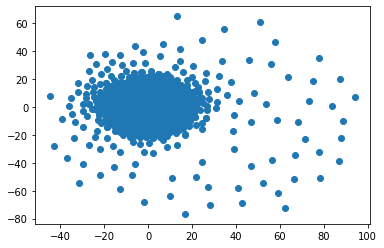

In [ ]:
plt.scatter(t[:,0], t[:,1])

In [ ]:
modelpath = FILELOC + 'reldate_weights_20211019_aligned.h5'

ENCDIM = 1500; NC = 300; NL = 1; NT = 1; NHEADS = 8; FFDIM = 64; NDENSE = 64
TRANSDROPRATE = 0.1; DROPRATE = 0.0; ismlen = 1273
BATCH_SIZE = 8

tf.keras.backend.clear_session()    # reset Tensorflow session
with tpu_strategy.scope():
    model = AttModel(L=ismlen, vocab_size=len(aa_list)+1, embdim = ENCDIM,
                        numheads = NHEADS, ffdim = FFDIM, num_dense = NDENSE,
                        mask_zero=True, dropout_rate = DROPRATE, trans_drop = TRANSDROPRATE,
                        Nt = NT, W = 1, Nc = NC, Nl = NL)      
    model.load_weights(FILELOC+'reldate_weights_20211019_aligned.h5')

    pred = model.predict(valtok, verbose=2, batch_size=BATCH_SIZE).ravel()

    get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('embedding_dense').output)
    get_embedding_model.compile()
    emb = get_embedding_model.predict(valtok, verbose=1, batch_size=BATCH_SIZE)

    get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
    get_attention_model.compile()
    att = get_attention_model.predict(valtok, verbose=1, batch_size=BATCH_SIZE)

7331/7331 - 120s
7331/7331 [==============================] - 119s 16ms/step


In [ ]:
t = TSNE(n_components=2, perplexity=50, init='pca', verbose=1).fit_transform(emb)
# t200 = TSNE(n_components=2, perplexity=200, init='pca', verbose=1).fit_transform(emb)
# t30 = TSNE(n_components=2, perplexity=30, init='pca', verbose=1).fit_transform(emb)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 58641 samples in 0.696s...
[t-SNE] Computed neighbors for 58641 samples in 40.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 58641
[t-SNE] Computed conditional probabilities for sample 2000 / 58641
[t-SNE] Computed conditional probabilities for sample 3000 / 58641
[t-SNE] Computed conditional probabilities for sample 4000 / 58641
[t-SNE] Computed conditional probabilities for sample 5000 / 58641
[t-SNE] Computed conditional probabilities for sample 6000 / 58641
[t-SNE] Computed conditional probabilities for sample 7000 / 58641
[t-SNE] Computed conditional probabilities for sample 8000 / 58641
[t-SNE] Computed conditional probabilities for sample 9000 / 58641
[t-SNE] Computed conditional probabilities for sample 10000 / 58641
[t-SNE] Computed conditional probabilities for sample 11000 / 58641
[t-SNE] Computed conditional probabilities for sample 12000 / 58641
[t-SNE] Computed conditional probabilities for s

In [ ]:
# with open(FILELOC + 'reldate_10192021_valdata.pkl', 'wb') as f:
#     pickle.dump([att, emb, pred, t, t200, t30], f)

# with open(FILELOC + 'reldate_10192021_aligned_valdata.pkl', 'wb') as f:
#     pickle.dump([att, emb, pred, t], f)

In [ ]:
# emb_pca = PCA(n_components=10)
# p = pca.fit_transform(emb)